In [206]:
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

import numpy as np

import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

from fbprophet import Prophet
 
import matplotlib

import statsmodels.api as sm

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [399]:
may = pd.read_csv('2018-04-26_through_2018-05-26.csv', sep='\t')
june = pd.read_csv('2018-05-27_through_2018-06-26.csv', sep='\t')
july = pd.read_csv('2018-06-27_through_2018-07-27.csv', sep='\t')
august = pd.read_csv('2018-07-28_through_2018-08-26.csv', sep='\t')
september = pd.read_csv('2018-08-27_through_2018-09-26.csv', sep='\t')
october = pd.read_csv('2018-09-27_through_2018-10-27.csv', sep='\t')
november = pd.read_csv('2018-10-28_through-2018-11-27.csv', sep='\t')
december = pd.read_csv('2018-11-28_through_2018-12-28.csv', sep='\t')

In [400]:
def drop_rows():
    june.drop(range(102, 107), inplace=True)
    june.reset_index(inplace=True, drop=True)
    november.drop(range(120, 133), inplace=True)
    november.drop(range(142, 156), inplace=True)
    november.drop(range(165, 178), inplace=True)
    november.drop(range(187, 190), inplace=True)
    november.drop(range(199, 208), inplace=True)
    november.drop(range(226, 233), inplace=True)
    november.drop(range(242, 258), inplace=True)
    november.reset_index(inplace=True, drop=True)

def calories_in_dataframe(df, start, finish):
    """Returns a DataFrame of dates and calories consumed."""
    date = []
    calories_in = []
    for i in df.Foods.loc[start:finish].str.split(',"'):
        date.append(i[0])
    #     print(date)
        calories_in.append(i[1])
    #     print(calories_in)
    date_calories_in = pd.DataFrame({'date':date, 'calories_in':calories_in})
    return date_calories_in

def fitness_data_dataframe(df, start, finish):
    """Returns a DataFrame of fitness data."""
    date = []
    cals_burned = []
    steps = []
    dist = []
    floors = []
    sedentary = []
    lightly_active = []
    fairly_active = []
    very_active = []
    activity_calories = []
    for i in df.Foods.loc[start:finish].str.split(',"'):
#         date.append(i[0])
        cals_burned.append(i[1])
        steps.append(i[2])
        dist.append(i[3])
        floors.append(i[4])
        sedentary.append(i[5])
        lightly_active.append(i[6])
        fairly_active.append(i[7])
        very_active.append(i[8])
        activity_calories.append(i[9])
    fitness_data = pd.DataFrame({'calories_burned':cals_burned, 'steps':steps, # date removed
                             'distance':dist, 'floors':floors, 'minutes_sedentary':sedentary, 
                             'minutes_lightly_active':lightly_active, 
                             'minutes_fairly_active':fairly_active, 
                             'minutes_very_active':very_active, 'activity_calories':activity_calories})   
    
    return fitness_data

def make_log_columns(df, column_name, row_to_start_at):
    """Used to make logs DataFrame. Goes through each log and grabs the required data."""
    for i in df.Foods.loc[row_to_start_at::9].str.split(',"'):
        column_name.append(i[2])

def logs_dataframe(df, first_calories_log):
    """Returns a DataFrame of log data."""
    calories = []
    make_log_columns(df, calories, first_calories_log)
    fat = []
    make_log_columns(df, fat, first_calories_log+1)
    fiber = []
    make_log_columns(df, fiber, first_calories_log+2)
    carbs = []
    make_log_columns(df, carbs, first_calories_log+3)
    sodium = []
    make_log_columns(df, sodium, first_calories_log+4)
    protein = []
    make_log_columns(df, protein, first_calories_log+5)
    water = []
    make_log_columns(df, water, first_calories_log+6)
    
    may_logs = pd.DataFrame({'calories':calories, 'fat (g)':fat, 'fiber (g)':fiber, 'carbs (g)':carbs, 
                             'sodium (mg)':sodium, 'protein (g)':protein, 'water (fl oz)':water})
    
    return may_logs

def create_month_dataframe(df, cals_start, cals_finish, fitness_start, fitness_finish, calories_log_start):
    calories_df = calories_in_dataframe(df=df, start=cals_start, finish=cals_finish)
    fitness_df = fitness_data_dataframe(df=df, start=fitness_start, finish=fitness_finish)
    logs_df = logs_dataframe(df=df, first_calories_log=calories_log_start)
    month_df = pd.concat([calories_df, fitness_df, logs_df], axis=1)
    return month_df

def create_all_dataframes():
    may_df = create_month_dataframe(may, 1, 31, 34, 64, 67)
    june_df = create_month_dataframe(june, 1, 31, 34, 64, 67) # need to delete rows 102 through 106
    july_df = create_month_dataframe(july, 1, 31, 34, 64, 67)
    august_df = create_month_dataframe(august, 1, 30, 33, 62, 65) # one less day, need to adjust
    september_df = create_month_dataframe(september, 1, 31, 34, 64, 67)
    october_df = create_month_dataframe(october, 1, 31, 34, 64, 67)
    november_df = create_month_dataframe(november, 1, 31, 34, 64, 67) # need to delete multiple rows
    december_df = create_month_dataframe(december, 1, 31, 34, 42, 45) # fitness data doesn't have full range of days
    return may_df, june_df, july_df, august_df, september_df, october_df, november_df, december_df
    
def string_to_num(df, column):
    new_series = []
    for i, row in enumerate(df[column]):
        new_row = []
        if type(row) == float:
                new_series.append(row)
                continue
        for char in row:
            if char == '.':
                new_row.append(char)
                continue
            if char.isdigit():
                new_row.append(char)
            if pd.isna(df[column][i]):
                continue
        new_series.append(''.join(new_row))
    df[column] = new_series
    
def only_numbers(df):
    cols = df.drop(columns='date').columns
    for col in cols:
        string_to_num(df, col)
        
def only_numbers_dataframe(may, june, july, august, sept, october, nov, dec):
    only_numbers(may)
    only_numbers(june)
    only_numbers(july)
    only_numbers(august)
    only_numbers(sept)
    only_numbers(october)
    only_numbers(nov)
    only_numbers(dec)
    
def correct_dtypes(df):
    cols = df.drop(columns='date').columns
    for col in cols:
        df[col] = df[col].astype(float)
    df.date = pd.to_datetime(df.date)
        
def correct_dtypes_dataframe():
    correct_dtypes(may)
    correct_dtypes(june)
    correct_dtypes(july)
    correct_dtypes(august)
    correct_dtypes(sept)
    correct_dtypes(october)
    correct_dtypes(nov)
    correct_dtypes(dec)
    
def combining_it_all():
    return pd.concat([may, june, july, august, sept, october, nov, dec])

### Dropping food log rows that disrupt the functions. Consider keeping them in another column in case it is relevant information.

In [401]:
drop_rows()

In [402]:
may, june, july, august, sept, october, nov, dec = create_all_dataframes()

In [403]:
only_numbers_dataframe(may, june, july, august, sept, october, nov, dec)

In [404]:
dec.head()

date calories_in calories_burned  steps distance floors  \
0  2018-11-28           0            3088   7602     3.59     16   
1  2018-11-29           0            3693  12380     6.56     18   
2  2018-11-30           0            3269   9559     4.51     14   
3  2018-12-01           0            3813  14510     7.27      7   
4  2018-12-02           0            3957  13257     6.23    195   

  minutes_sedentary minutes_lightly_active minutes_fairly_active  \
0               717                    272                     0   
1               717                    258                    15   
2               699                    288                    12   
3               527                    233                    22   
4               725                    265                    13   

  minutes_very_active activity_calories calories fat (g) fiber (g) carbs (g)  \
0                   0              1361        0       0         0         0   
1                  53              2051        0       0         0         0   
2                   6              1577        0       0         0         0   
3                  67              2124        0       0         0         0   
4                  70              2305        0       0         0         0   

  sodium (mg) protein (g) water (fl oz)  
0           0           0             0  
1           0           0             0  
2           0           0             0  
3           0           0             0  
4           0           0             0

In [405]:
correct_dtypes_dataframe()

In [406]:
may.dtypes

date                      datetime64[ns]
calories_in                      float64
calories_burned                  float64
steps                            float64
distance                         float64
floors                           float64
minutes_sedentary                float64
minutes_lightly_active           float64
minutes_fairly_active            float64
minutes_very_active              float64
activity_calories                float64
calories                         float64
fat (g)                          float64
fiber (g)                        float64
carbs (g)                        float64
sodium (mg)                      float64
protein (g)                      float64
water (fl oz)                    float64
dtype: object

In [407]:
dec.head()

date  calories_in  calories_burned    steps  distance  floors  \
0 2018-11-28          0.0           3088.0   7602.0      3.59    16.0   
1 2018-11-29          0.0           3693.0  12380.0      6.56    18.0   
2 2018-11-30          0.0           3269.0   9559.0      4.51    14.0   
3 2018-12-01          0.0           3813.0  14510.0      7.27     7.0   
4 2018-12-02          0.0           3957.0  13257.0      6.23   195.0   

   minutes_sedentary  minutes_lightly_active  minutes_fairly_active  \
0              717.0                   272.0                    0.0   
1              717.0                   258.0                   15.0   
2              699.0                   288.0                   12.0   
3              527.0                   233.0                   22.0   
4              725.0                   265.0                   13.0   

   minutes_very_active  activity_calories  calories  fat (g)  fiber (g)  \
0                  0.0             1361.0       0.0      0.0        0.0   
1                 53.0             2051.0       0.0      0.0        0.0   
2                  6.0             1577.0       0.0      0.0        0.0   
3                 67.0             2124.0       0.0      0.0        0.0   
4                 70.0             2305.0       0.0      0.0        0.0   

   carbs (g)  sodium (mg)  protein (g)  water (fl oz)  
0        0.0          0.0          0.0            0.0  
1        0.0          0.0          0.0            0.0  
2        0.0          0.0          0.0            0.0  
3        0.0          0.0          0.0            0.0  
4        0.0          0.0          0.0            0.0

In [408]:
fitbit = combining_it_all()
pd.concat([fitbit.head(), fitbit.tail()])

date  calories_in  calories_burned   steps  distance  floors  \
0  2018-04-26          0.0           2635.0  2931.0      1.38     2.0   
1  2018-04-27          0.0           3649.0  9971.0      4.70    19.0   
2  2018-04-28          0.0           3379.0  3521.0      1.66     2.0   
3  2018-04-29          0.0           2851.0  1639.0      0.77     0.0   
4  2018-04-30          0.0           2825.0  1323.0      0.62     0.0   
26 2018-12-24          0.0              NaN     NaN       NaN     NaN   
27 2018-12-25          0.0              NaN     NaN       NaN     NaN   
28 2018-12-26          0.0              NaN     NaN       NaN     NaN   
29 2018-12-27          0.0              NaN     NaN       NaN     NaN   
30 2018-12-28          0.0              NaN     NaN       NaN     NaN   

    minutes_sedentary  minutes_lightly_active  minutes_fairly_active  \
0              1347.0                    93.0                    0.0   
1              1158.0                   219.0                   46.0   
2               702.0                   155.0                   22.0   
3               891.0                   122.0                    0.0   
4               880.0                   104.0                    0.0   
26                NaN                     NaN                    NaN   
27                NaN                     NaN                    NaN   
28                NaN                     NaN                    NaN   
29                NaN                     NaN                    NaN   
30                NaN                     NaN                    NaN   

    minutes_very_active  activity_calories  calories  fat (g)  fiber (g)  \
0                   0.0              566.0       0.0      0.0        0.0   
1                  17.0             1752.0       0.0      0.0        0.0   
2                  11.0             1124.0       0.0      0.0        0.0   
3                   0.0              602.0       0.0      0.0        0.0   
4                   0.0              540.0       0.0      0.0        0.0   
26                  NaN                NaN       0.0      0.0        0.0   
27                  NaN                NaN       0.0      0.0        0.0   
28                  NaN                NaN       0.0      0.0        0.0   
29                  NaN                NaN       0.0      0.0        0.0   
30                  NaN                NaN       0.0      0.0        0.0   

    carbs (g)  sodium (mg)  protein (g)  water (fl oz)  
0         0.0          0.0          0.0            0.0  
1         0.0          0.0          0.0            0.0  
2         0.0          0.0          0.0            0.0  
3         0.0          0.0          0.0            0.0  
4         0.0          0.0          0.0            0.0  
26        0.0          0.0          0.0            0.0  
27        0.0          0.0          0.0            0.0  
28        0.0          0.0          0.0            0.0  
29        0.0          0.0          0.0            0.0  
30        0.0          0.0          0.0            0.0

In [114]:
fitbit.shape[0]/30

8.233333333333333

In [13]:
# test = pd.DataFrame(dict(col=['1', '2', '3'], col2=['12.3asd', '12,000.rgw', '4.54dfs']))
# test

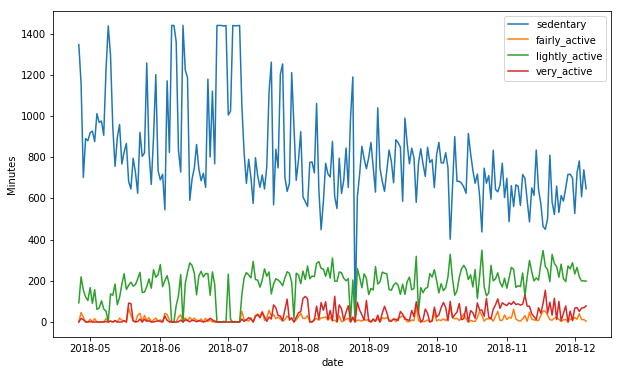

In [115]:
plt.figure(figsize=(10,6))
sns.lineplot(x=fitbit.date, y=fitbit.minutes_sedentary, label='sedentary')
sns.lineplot(x=fitbit.date, y=fitbit.minutes_fairly_active, label='fairly_active')
sns.lineplot(x=fitbit.date, y=fitbit.minutes_lightly_active, label='lightly_active')
sns.lineplot(x=fitbit.date, y=fitbit.minutes_very_active, label='very_active')
plt.ylabel('Minutes')
plt.show()

In [409]:
fitbit['day_of_week'] = fitbit.date.dt.day_name()

In [410]:
fitbit['weekend_or_weekday'] = fitbit.day_of_week.str.startswith('S')

In [411]:
fitbit.loc[fitbit.weekend_or_weekday == True, 'weekend_or_weekday'] = 'weekend'
fitbit.loc[fitbit.weekend_or_weekday == False, 'weekend_or_weekday'] = 'weekday'

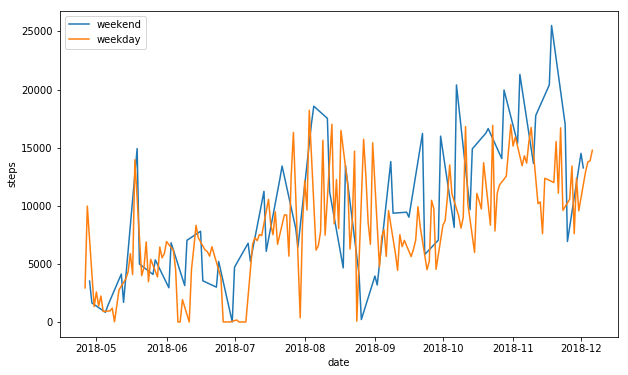

In [412]:
weekend = fitbit.loc[fitbit.weekend_or_weekday == 'weekend']
weekday = fitbit.loc[fitbit.weekend_or_weekday == 'weekday']

plt.figure(figsize=(10, 6))
sns.lineplot(data=weekend, x=weekend.date, y=weekend.steps, label='weekend')
sns.lineplot(data=weekday, x=weekday.date, y=weekday.steps, label='weekday')

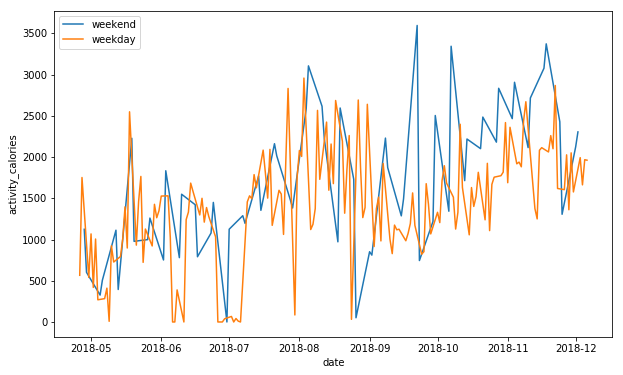

In [120]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=weekend, x=weekend.date, y=weekend.activity_calories, label='weekend')
sns.lineplot(data=weekday, x=weekday.date, y=weekday.activity_calories, label='weekday')

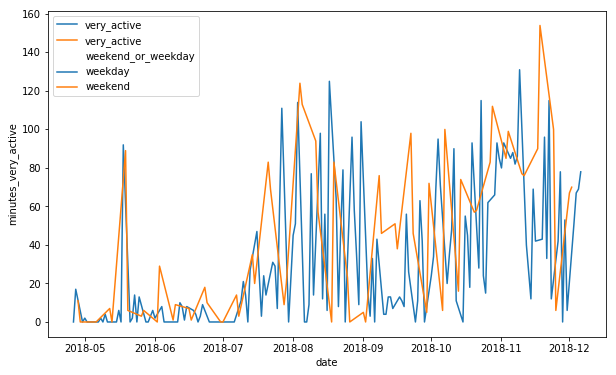

In [121]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=fitbit.date, y=fitbit.minutes_very_active, label='very_active', hue=fitbit.weekend_or_weekday)

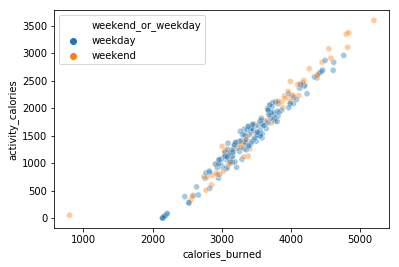

In [122]:
sns.scatterplot(x=fitbit.calories_burned, y=fitbit.activity_calories, hue=fitbit.weekend_or_weekday, alpha=.4)

Looking at the heatmap below, there might be a good reason to run some regression models after steps are predicted with time series to predict for distance, minutes_very_active, and activity_calories since they have such high correlation.  These regression models can then be compared to our TSA models.

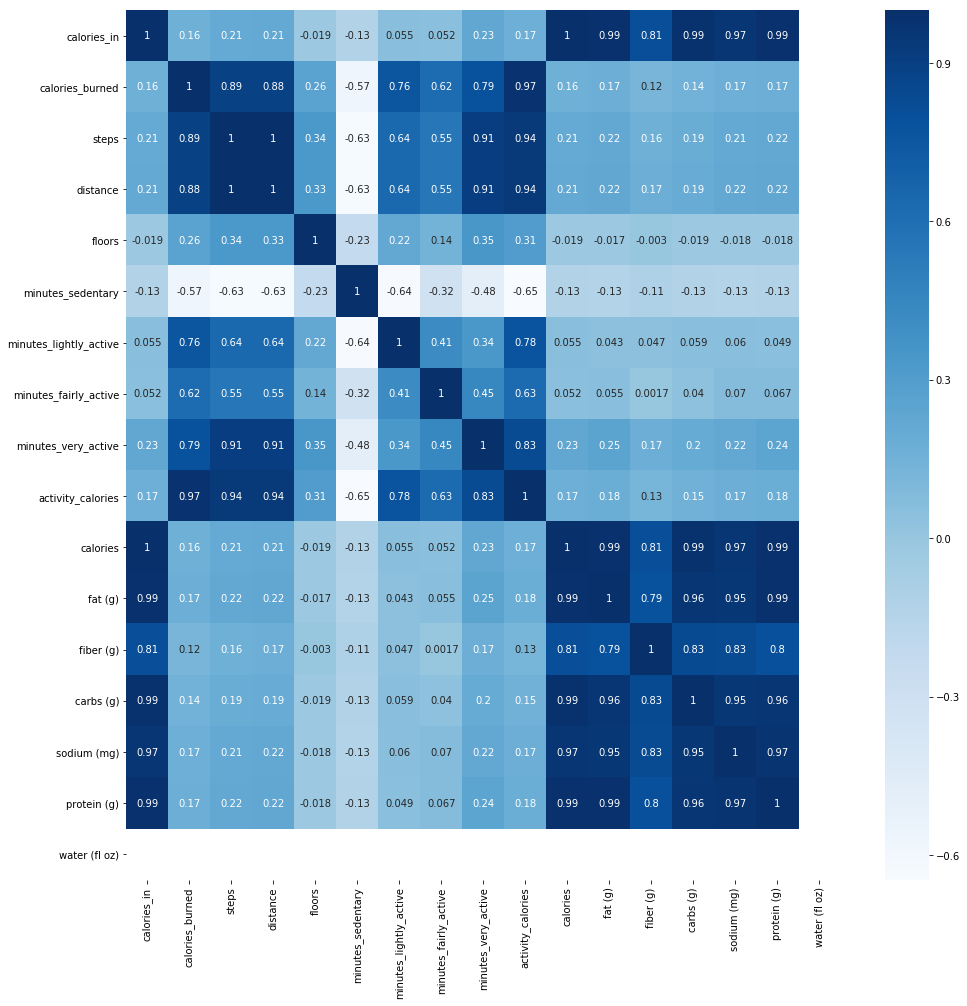

In [205]:
plt.figure(figsize=(16,16))
sns.heatmap(fitbit.corr(), cmap='Blues', annot=True)

In [533]:
to_predict = fitbit.loc[fitbit.calories_burned.isna()]

In [534]:
to_predict.isna().sum()

calories_burned           22
steps                     22
distance                  22
floors                    22
minutes_sedentary         22
minutes_lightly_active    22
minutes_fairly_active     22
minutes_very_active       22
activity_calories         22
calories                   0
fat (g)                    0
fiber (g)                  0
carbs (g)                  0
sodium (mg)                0
protein (g)                0
water (fl oz)              0
day_of_week                0
weekend_or_weekday         0
total_minutes             22
hours_awake               22
hours_asleep              22
dtype: int64

In [535]:
list(to_predict)

['calories_burned',
 'steps',
 'distance',
 'floors',
 'minutes_sedentary',
 'minutes_lightly_active',
 'minutes_fairly_active',
 'minutes_very_active',
 'activity_calories',
 'calories',
 'fat (g)',
 'fiber (g)',
 'carbs (g)',
 'sodium (mg)',
 'protein (g)',
 'water (fl oz)',
 'day_of_week',
 'weekend_or_weekday',
 'total_minutes',
 'hours_awake',
 'hours_asleep']

In [536]:
to_predict = to_predict[['calories_burned', 
    'steps',
    'distance',
    'floors',
    'minutes_sedentary',
    'minutes_lightly_active',
    'minutes_fairly_active',
    'minutes_very_active',
    'activity_calories']]
to_predict

calories_burned  steps  distance  floors  minutes_sedentary  \
date                                                                      
2018-12-07              NaN    NaN       NaN     NaN                NaN   
2018-12-08              NaN    NaN       NaN     NaN                NaN   
2018-12-09              NaN    NaN       NaN     NaN                NaN   
2018-12-10              NaN    NaN       NaN     NaN                NaN   
2018-12-11              NaN    NaN       NaN     NaN                NaN   
2018-12-12              NaN    NaN       NaN     NaN                NaN   
2018-12-13              NaN    NaN       NaN     NaN                NaN   
2018-12-14              NaN    NaN       NaN     NaN                NaN   
2018-12-15              NaN    NaN       NaN     NaN                NaN   
2018-12-16              NaN    NaN       NaN     NaN                NaN   
2018-12-17              NaN    NaN       NaN     NaN                NaN   
2018-12-18              NaN    NaN       NaN     NaN                NaN   
2018-12-19              NaN    NaN       NaN     NaN                NaN   
2018-12-20              NaN    NaN       NaN     NaN                NaN   
2018-12-21              NaN    NaN       NaN     NaN                NaN   
2018-12-22              NaN    NaN       NaN     NaN                NaN   
2018-12-23              NaN    NaN       NaN     NaN                NaN   
2018-12-24              NaN    NaN       NaN     NaN                NaN   
2018-12-25              NaN    NaN       NaN     NaN                NaN   
2018-12-26              NaN    NaN       NaN     NaN                NaN   
2018-12-27              NaN    NaN       NaN     NaN                NaN   
2018-12-28              NaN    NaN       NaN     NaN                NaN   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-12-07                     NaN                    NaN   
2018-12-08                     NaN                    NaN   
2018-12-09                     NaN                    NaN   
2018-12-10                     NaN                    NaN   
2018-12-11                     NaN                    NaN   
2018-12-12                     NaN                    NaN   
2018-12-13                     NaN                    NaN   
2018-12-14                     NaN                    NaN   
2018-12-15                     NaN                    NaN   
2018-12-16                     NaN                    NaN   
2018-12-17                     NaN                    NaN   
2018-12-18                     NaN                    NaN   
2018-12-19                     NaN                    NaN   
2018-12-20                     NaN                    NaN   
2018-12-21                     NaN                    NaN   
2018-12-22                     NaN                    NaN   
2018-12-23                     NaN                    NaN   
2018-12-24                     NaN                    NaN   
2018-12-25                     NaN                    NaN   
2018-12-26                     NaN                    NaN   
2018-12-27                     NaN                    NaN   
2018-12-28                     NaN                    NaN   

            minutes_very_active  activity_calories  
date                                                
2018-12-07                  NaN                NaN  
2018-12-08                  NaN                NaN  
2018-12-09                  NaN                NaN  
2018-12-10                  NaN                NaN  
2018-12-11                  NaN                NaN  
2018-12-12                  NaN                NaN  
2018-12-13                  NaN                NaN  
2018-12-14                  NaN                NaN  
2018-12-15                  NaN                NaN  
2018-12-16                  NaN                NaN  
2018-12-17                  NaN                NaN  
2018-12-18                  NaN                NaN  
2018

In [413]:
fitbit.set_index('date', inplace=True)
fitbit.head(3)

calories_in  calories_burned   steps  distance  floors  \
date                                                                 
2018-04-26          0.0           2635.0  2931.0      1.38     2.0   
2018-04-27          0.0           3649.0  9971.0      4.70    19.0   
2018-04-28          0.0           3379.0  3521.0      1.66     2.0   

            minutes_sedentary  minutes_lightly_active  minutes_fairly_active  \
date                                                                           
2018-04-26             1347.0                    93.0                    0.0   
2018-04-27             1158.0                   219.0                   46.0   
2018-04-28              702.0                   155.0                   22.0   

            minutes_very_active  activity_calories  calories  fat (g)  \
date                                                                    
2018-04-26                  0.0              566.0       0.0      0.0   
2018-04-27                 17.0             1752.0       0.0      0.0   
2018-04-28                 11.0             1124.0       0.0      0.0   

            fiber (g)  carbs (g)  sodium (mg)  protein (g)  water (fl oz)  \
date                                                                        
2018-04-26        0.0        0.0          0.0          0.0            0.0   
2018-04-27        0.0        0.0          0.0          0.0            0.0   
2018-04-28        0.0        0.0          0.0          0.0            0.0   

           day_of_week weekend_or_weekday  
date                                       
2018-04-26    Thursday            weekday  
2018-04-27      Friday            weekday  
2018-04-28    Saturday            weekend

In [198]:
train = fitbit.steps[:194]
test = fitbit.steps[194:225]
to_predict_steps = fitbit.steps[225:]

In [199]:
print('Train size' + str(train.shape))
print('Test size' + str(test.shape))
print('To predict size' + str(to_predict_steps.shape))

Train size(194,)
Test size(31,)
To predict size(22,)


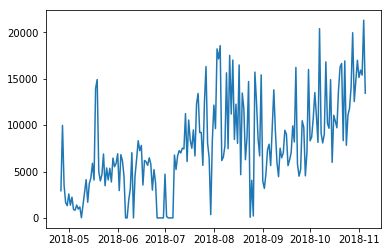

In [200]:
plt.plot(train)

In [201]:
yhat = pd.DataFrame(dict(actual=test))
yhat['avg_steps'] = train.mean()
yhat.head()

actual    avg_steps
date                            
2018-11-06  14300.0  7757.231959
2018-11-07  13664.0  7757.231959
2018-11-08  15542.0  7757.231959
2018-11-09  16732.0  7757.231959
2018-11-10  13636.0  7757.231959

In [202]:
def plot_data_and_predictions(predictions, label):
    
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

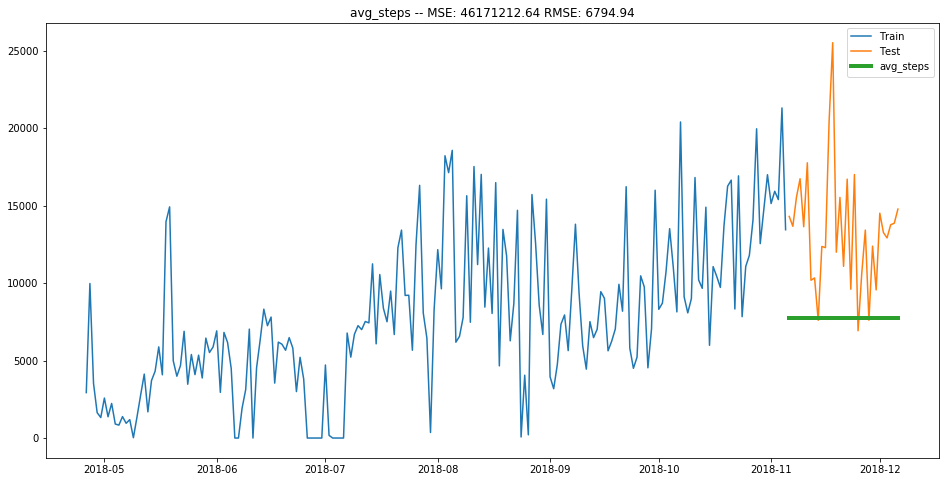

In [203]:
plot_and_eval(yhat_steps.avg_steps)

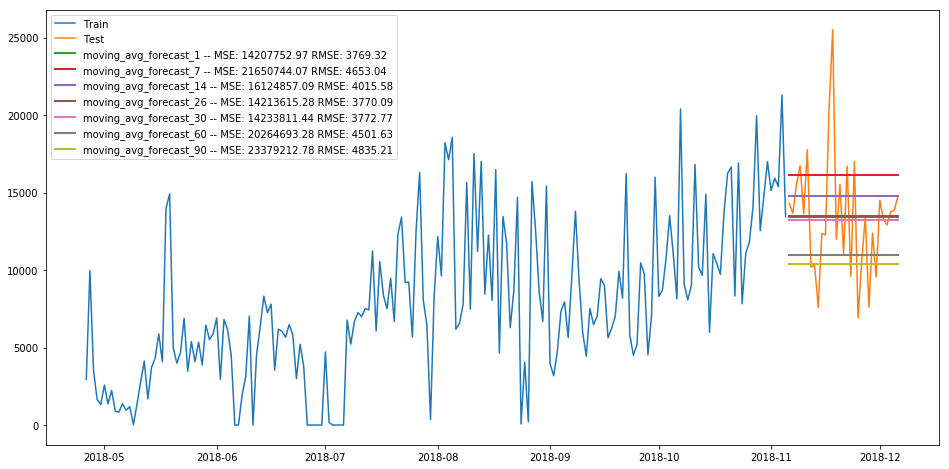

In [309]:
period_vals = [1, 7, 14, 26, 30, 60, 90]

for periods in period_vals:
    yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).mean().iloc[-1]

forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

plot_and_eval(forecasts, linewidth=2)

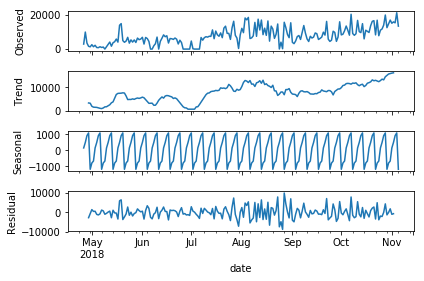

In [39]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

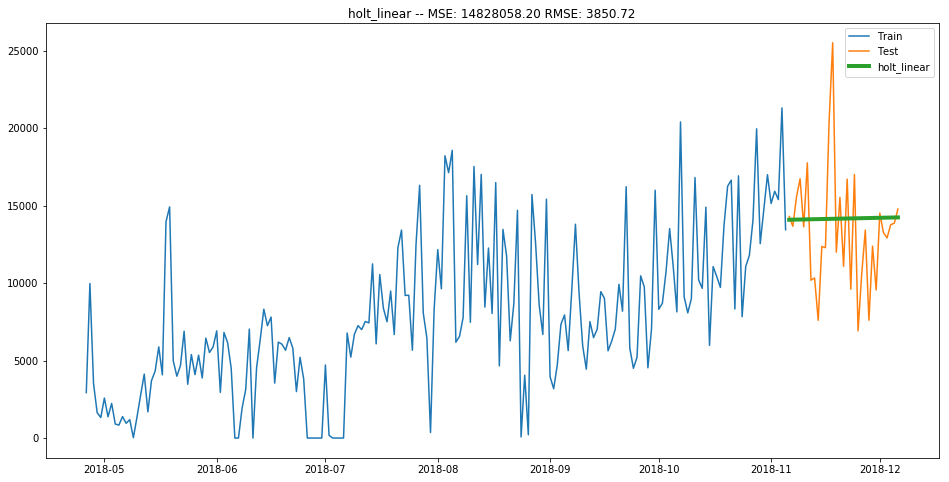

In [94]:
from statsmodels.tsa.api import Holt

holt = Holt(train).fit(smoothing_level=.92, smoothing_slope=.08)
yhat['holt_linear'] = holt.forecast(test.shape[0])

plot_and_eval(yhat.holt_linear)

In [42]:
train_df = train.to_frame()
train_df.head(3)

steps
date              
2018-04-26  2931.0
2018-04-27  9971.0
2018-04-28  3521.0

In [44]:
train_df.reset_index(inplace=True)
train_df.dtypes

date     datetime64[ns]
steps           float64
dtype: object

In [45]:
train_df.rename(index=str, columns={'date':'ds'}, inplace=True)
train_df.head(3)

ds   steps
0 2018-04-26  2931.0
1 2018-04-27  9971.0
2 2018-04-28  3521.0

In [48]:
train_df.rename(index=str, columns={'steps':'y'}, inplace=True)
train_df.head(3)

ds       y  cap  floor
0 2018-04-26  2931.0  100  30000
1 2018-04-27  9971.0  100  30000
2 2018-04-28  3521.0  100  30000

In [46]:
train_df.shape

(194, 2)

In [50]:
train_df['cap'] = 30000
train_df['floor'] = 100

m = Prophet(growth='logistic', changepoint_range=0.9)
m.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [55]:
future = m.make_future_dataframe(periods=31)
future['cap'] = 30000
future['floor'] = 100
print(future.head())
print(future.tail())
print(train_df.tail())

          ds    cap  floor
0 2018-04-26  30000    100
1 2018-04-27  30000    100
2 2018-04-28  30000    100
3 2018-04-29  30000    100
4 2018-04-30  30000    100
            ds    cap  floor
220 2018-12-02  30000    100
221 2018-12-03  30000    100
222 2018-12-04  30000    100
223 2018-12-05  30000    100
224 2018-12-06  30000    100
            ds        y    cap  floor
189 2018-11-01  15134.0  30000    100
190 2018-11-02  15924.0  30000    100
191 2018-11-03  15388.0  30000    100
192 2018-11-04  21302.0  30000    100
193 2018-11-05  13441.0  30000    100


In [64]:
forecast = m.predict(future)
forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(31)
forecast_df.shape

(31, 4)

In [65]:
test_df = test.to_frame()
test_df.shape

(31, 1)

In [66]:
test_df.head(3)

steps
date               
2018-11-06  14300.0
2018-11-07  13664.0
2018-11-08  15542.0

In [67]:
forecast_df.set_index('ds', inplace=True)
forecast_df.head(3)

yhat   yhat_lower    yhat_upper
ds                                                 
2018-11-06  13078.209238  7932.543154  18150.454729
2018-11-07  13294.901137  8187.972545  18092.838253
2018-11-08  14262.063902  9299.141058  19482.497189

In [69]:
forecast_df = forecast_df.join(test_df)
forecast_df.head(3)

yhat   yhat_lower    yhat_upper    steps
ds                                                          
2018-11-06  13078.209238  7932.543154  18150.454729  14300.0
2018-11-07  13294.901137  8187.972545  18092.838253  13664.0
2018-11-08  14262.063902  9299.141058  19482.497189  15542.0

In [72]:
forecast_df.yhat = forecast_df.yhat.astype(int)

In [75]:
forecast_df

yhat    yhat_lower    yhat_upper    steps
ds                                                    
2018-11-06  13078   7932.543154  18150.454729  14300.0
2018-11-07  13294   8187.972545  18092.838253  13664.0
2018-11-08  14262   9299.141058  19482.497189  15542.0
2018-11-09  14945   9731.580916  19619.534905  16732.0
2018-11-10  15152   9945.267931  19734.537538  13636.0
2018-11-11  15667  10566.588409  20741.938963  17761.0
2018-11-12  13196   8652.039584  18489.022041  10184.0
2018-11-13  13626   9280.187881  18459.933665  10330.0
2018-11-14  13843   8734.735974  18878.966553   7598.0
2018-11-15  14810   9761.916841  19656.472958  12360.0
2018-11-16  15494  10611.673799  20839.854072  12286.0
2018-11-17  15701  10602.929357  20420.996126  20395.0
2018-11-18  16217  11208.068326  21108.970687  25512.0
2018-11-19  13745   8868.734674  18861.570208  11993.0
2018-11-20  14175   8851.692060  19074.825856  15527.0
2018-11-21  14392   9560.153986  19648.127573  11079.0
2018-11-22  15360  10147.670325  20339.001142  16705.0
2018-11-23  16044  11095.819647  21156.592272   9602.0
2018-11-24  16251  11476.240714  21476.993802  17004.0
2018-11-25  16766  11735.041220  21359.168710   6921.0
2018-11-26  14295   9165.402395  19517.271800  10563.0
2018-11-27  14725   9793.732455  19766.265121  13420.0
2018-11-28  14941   9957.928821  19785.434297   7602.0
2018-11-29  15909  11006.487053  20975.199928  12380.0
2018-11-30  16592  11616.925793  21706.214590   9559.0
2018-12-01  16799  11715.211964  21821.864278  14510.0
2018-12-02  17315  12138.177388  22495.801200  13257.0
2018-12-03  14843   9863.101354  20149.725312  12915.0
2018-12-04  15272  10259.687636  20144.013692  13763.0
2018-12-05  15489  10436.552975  20164.963322  13865.0
2018-12-06  16456  11181.463840  21358.730952  14774.0

In [76]:
forecast_df['error'] = forecast_df['steps'] - forecast_df['yhat']
forecast_df.head(3)

yhat   yhat_lower    yhat_upper    steps   error
ds                                                           
2018-11-06  13078  7932.543154  18150.454729  14300.0  1222.0
2018-11-07  13294  8187.972545  18092.838253  13664.0   370.0
2018-11-08  14262  9299.141058  19482.497189  15542.0  1280.0

In [133]:
forecast_df['abs_error'] = abs(forecast_df['error'])
forecast_df.head(10)

yhat    yhat_lower    yhat_upper    steps   error  abs_error
ds                                                                       
2018-11-06  13078   7932.543154  18150.454729  14300.0  1222.0     1222.0
2018-11-07  13294   8187.972545  18092.838253  13664.0   370.0      370.0
2018-11-08  14262   9299.141058  19482.497189  15542.0  1280.0     1280.0
2018-11-09  14945   9731.580916  19619.534905  16732.0  1787.0     1787.0
2018-11-10  15152   9945.267931  19734.537538  13636.0 -1516.0     1516.0
2018-11-11  15667  10566.588409  20741.938963  17761.0  2094.0     2094.0
2018-11-12  13196   8652.039584  18489.022041  10184.0 -3012.0     3012.0
2018-11-13  13626   9280.187881  18459.933665  10330.0 -3296.0     3296.0
2018-11-14  13843   8734.735974  18878.966553   7598.0 -6245.0     6245.0
2018-11-15  14810   9761.916841  19656.472958  12360.0 -2450.0     2450.0

In [134]:
forecast_df.abs_error.sum()/forecast_df.shape[0]

3267.7096774193546

In [135]:
forecast_df['sqr_error'] = forecast_df['abs_error'] ** 2
forecast_df.head(10)

yhat    yhat_lower    yhat_upper    steps   error  abs_error  \
ds                                                                          
2018-11-06  13078   7932.543154  18150.454729  14300.0  1222.0     1222.0   
2018-11-07  13294   8187.972545  18092.838253  13664.0   370.0      370.0   
2018-11-08  14262   9299.141058  19482.497189  15542.0  1280.0     1280.0   
2018-11-09  14945   9731.580916  19619.534905  16732.0  1787.0     1787.0   
2018-11-10  15152   9945.267931  19734.537538  13636.0 -1516.0     1516.0   
2018-11-11  15667  10566.588409  20741.938963  17761.0  2094.0     2094.0   
2018-11-12  13196   8652.039584  18489.022041  10184.0 -3012.0     3012.0   
2018-11-13  13626   9280.187881  18459.933665  10330.0 -3296.0     3296.0   
2018-11-14  13843   8734.735974  18878.966553   7598.0 -6245.0     6245.0   
2018-11-15  14810   9761.916841  19656.472958  12360.0 -2450.0     2450.0   

             sqr_error  
ds                      
2018-11-06   1493284.0  
2018-11-07    136900.0  
2018-11-08   1638400.0  
2018-11-09   3193369.0  
2018-11-10   2298256.0  
2018-11-11   4384836.0  
2018-11-12   9072144.0  
2018-11-13  10863616.0  
2018-11-14  39000025.0  
2018-11-15   6002500.0

In [143]:
(forecast_df.sqr_error.sum()/forecast_df.shape[0]) ** .5 

4087.961890643654

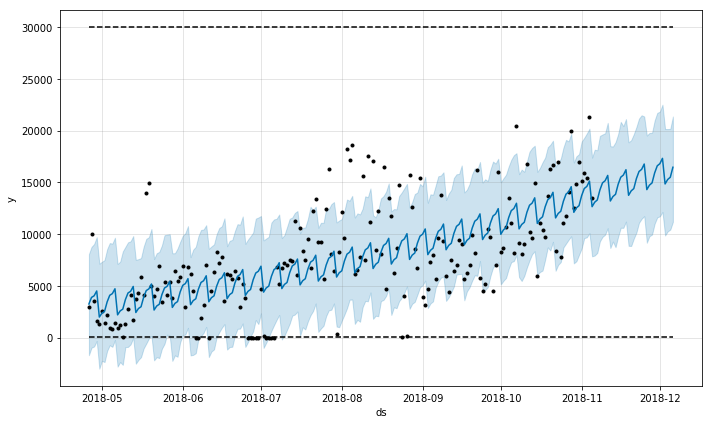

In [81]:
fig1 = m.plot(forecast)

In [96]:
list(fitbit)

['calories_in',
 'calories_burned',
 'steps',
 'distance',
 'floors',
 'minutes_sedentary',
 'minutes_lightly_active',
 'minutes_fairly_active',
 'minutes_very_active',
 'activity_calories',
 'calories',
 'fat (g)',
 'fiber (g)',
 'carbs (g)',
 'sodium (mg)',
 'protein (g)',
 'water (fl oz)',
 'day_of_week',
 'weekend_or_weekday']

In [99]:
low = fitbit['steps'].quantile(0.01)
high = fitbit['steps'].quantile(0.99)
print(low, high)

0.0 20395.76


In [100]:
def find_outliers(df):
    cols = list(df)
    for col in cols:
        low = df[col].quantile(0.01)
        high = df[col].quantile(0.99)
        print(col + ':')
        print(low, high)

In [132]:
find_outliers(fitbit)

calories_in:
0.0 2054.2799999999997
calories_burned:
2144.0 4813.44
steps:
0.0 20395.76
distance:
0.0 9.946799999999996
floors:
0.0 154.0799999999997
minutes_sedentary:
439.64 1440.0
minutes_lightly_active:
0.0 328.76
minutes_fairly_active:
0.0 65.79999999999995
minutes_very_active:
0.0 124.75999999999999
activity_calories:
0.0 3286.879999999998
calories:
0.0 2054.2799999999997
fat (g):
0.0 76.53999999999999
fiber (g):
0.0 15.159999999999968
carbs (g):
0.0 212.91999999999962
sodium (mg):
0.0 4980.619999999995
protein (g):
0.0 94.53999999999999
water (fl oz):
0.0 0.0


TypeError: can't multiply sequence by non-int of type 'float'

In [178]:
train = fitbit.steps[:194].to_frame()
test = fitbit.steps[194:225].to_frame()

In [179]:
train.shape

(194, 1)

In [180]:
test.shape

(31, 1)

In [181]:
train.head(3)

steps
date              
2018-04-26  2931.0
2018-04-27  9971.0
2018-04-28  3521.0

In [194]:
test.head()

date
2018-11-30    332655.0
2018-12-31     83084.0
Freq: M, Name: steps, dtype: float64

In [182]:
aggregation = 'sum'
train = train.steps.resample('M').agg(aggregation)
test = test.steps.resample('M').agg(aggregation)

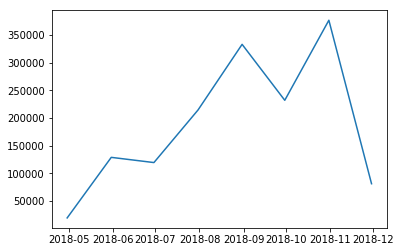

In [183]:
plt.plot(train)

In [184]:
yhat = pd.DataFrame(dict(actual=test))
yhat['avg_steps'] = train.mean()
yhat.head()

actual   avg_steps
date                            
2018-11-30  332655.0  188112.875
2018-12-31   83084.0  188112.875

In [185]:
def plot_data_and_predictions(predictions, label):
    
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

ValueError: Found input variables with inconsistent numbers of samples: [2, 31]

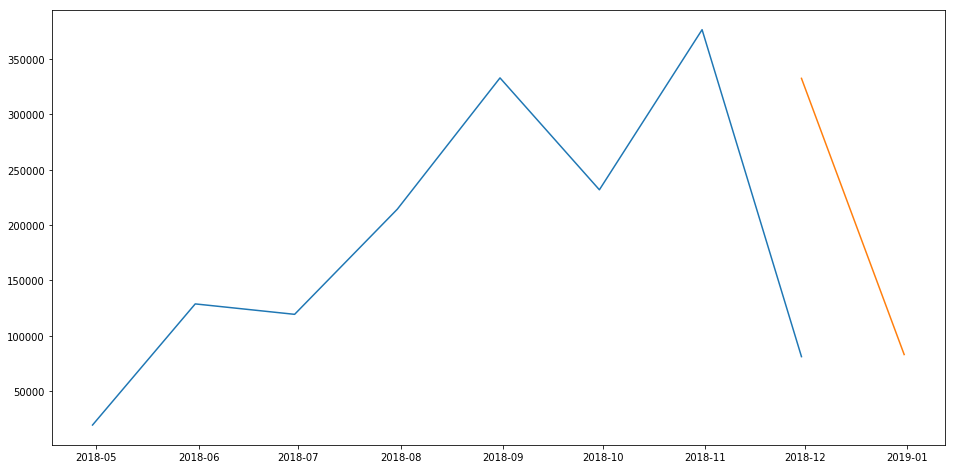

In [186]:
plot_and_eval(yhat_steps.avg_steps)

In [195]:
periods = 1
yhat['moving_avg_forecast_1'] = train.rolling(periods).mean().iloc[-1]

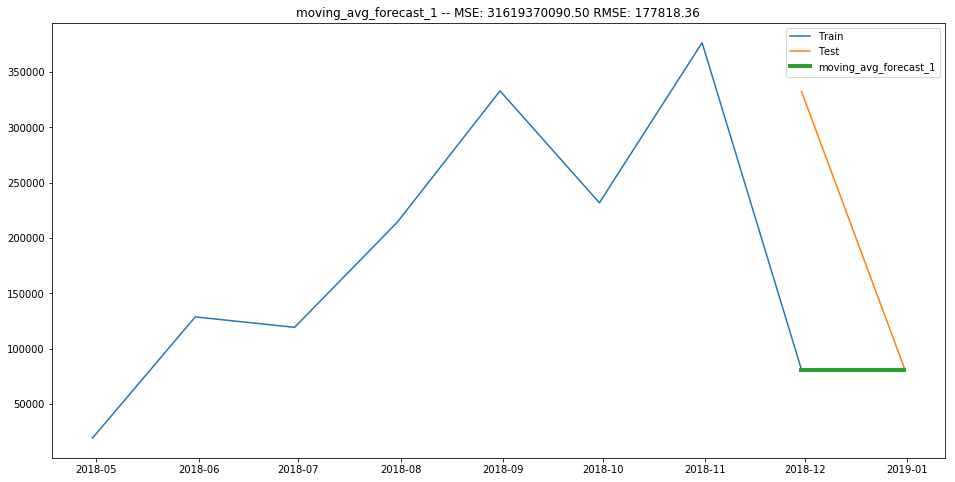

In [196]:
plot_and_eval(yhat.moving_avg_forecast_1)

In [207]:
train_distance = fitbit.iloc[:194]
test_distance = fitbit.iloc[194:225]
to_predict_distance = fitbit.iloc[225:]

In [330]:
train_distance.head(3)

calories_in  calories_burned   steps  distance  floors  \
date                                                                 
2018-04-26          0.0           2635.0  2931.0      1.38     2.0   
2018-04-27          0.0           3649.0  9971.0      4.70    19.0   
2018-04-28          0.0           3379.0  3521.0      1.66     2.0   

            minutes_sedentary  minutes_lightly_active  minutes_fairly_active  \
date                                                                           
2018-04-26             1347.0                    93.0                    0.0   
2018-04-27             1158.0                   219.0                   46.0   
2018-04-28              702.0                   155.0                   22.0   

            minutes_very_active  activity_calories  calories  fat (g)  \
date                                                                    
2018-04-26                  0.0              566.0       0.0      0.0   
2018-04-27                 17.0             1752.0       0.0      0.0   
2018-04-28                 11.0             1124.0       0.0      0.0   

            fiber (g)  carbs (g)  sodium (mg)  protein (g)  water (fl oz)  \
date                                                                        
2018-04-26        0.0        0.0          0.0          0.0            0.0   
2018-04-27        0.0        0.0          0.0          0.0            0.0   
2018-04-28        0.0        0.0          0.0          0.0            0.0   

           day_of_week weekend_or_weekday  
date                                       
2018-04-26    Thursday            weekday  
2018-04-27      Friday            weekday  
2018-04-28    Saturday            weekend

In [248]:
X_train_distance = train_distance[['steps']]
X_test_distance = test_distance[['steps']]
y_train_distance = train_distance[['distance']]
y_test_distance = test_distance[['distance']]
print(X_train_distance.shape)
print(X_test_distance.shape)
print(y_train_distance.shape)
print(y_test_distance.shape)

(194, 1)
(31, 1)
(194, 1)
(31, 1)


In [238]:
y_train_minutes_very_active = train_distance[['minutes_very_active']]
y_test_minutes_very_active = test_distance[['minutes_very_active']]

In [247]:
y_train_activity_calories = train_distance[['activity_calories']]
y_test_activity_calories = test_distance[['activity_calories']]

In [240]:
def linear_regression_train(X_df_train, X_df_test, y_df_train, y_df_test):
    print('PearsonR for train:')
    print('  '+ str([[col, pearsonr(X_df_train[col], y_df_train.iloc[:,0])] for col in X_df_train] ))
    print('-----')
    
    ols_model = sm.OLS(y_df_train, X_df_train)
    fit = ols_model.fit()
    print(fit.summary())
    print('-----')
    
    columns = list(X_df_train)
    
    lm1 = LinearRegression()
    lm1.fit(X_df_train[columns], y_df_train)
    lm1_y_intercept = lm1.intercept_
    print('lm1 y_intercept for train:')
    print(lm1_y_intercept)
    lm1_coefficients = lm1.coef_
    print('lm1_coefficients for train: ')
    print(lm1_coefficients)

    pred_lm1_train = lm1.predict(X_df_train)

    sum_of_lm1_pred_residuals_train = abs(pred_lm1_train).sum()
    print('Sum of predicted residuals for lm1 on train sample: ')
    print(sum_of_lm1_pred_residuals_train)
    mse_lm1_train = mean_squared_error(y_df_train, pred_lm1_train)
    print("Mean squared error for train set: %.6f" % mse_lm1_train)
    
    r2_lm1 = r2_score(y_df_train, pred_lm1_train)

    print('  {:.2%} of the variance in the distance can be explained by these features.'.format(r2_lm1))
    
    

In [288]:
def linear_regression_test(X_df_train, X_df_test, y_df_train, y_df_test):
    print('PearsonR for train:')
    print('  '+ str([[col, pearsonr(X_df_train[col], y_df_train.iloc[:,0])] for col in X_df_train] ))
    print('-----')
    
    ols_model = sm.OLS(y_df_train, X_df_train)
    fit = ols_model.fit()
    print(fit.summary())
    print('-----')
    
    columns = list(X_df_train)
    
    lm1 = LinearRegression()
    lm1.fit(X_df_train[columns], y_df_train)
    lm1_y_intercept = lm1.intercept_
    print('lm1 y_intercept for train:')
    print(lm1_y_intercept)
    lm1_coefficients = lm1.coef_
    print('lm1_coefficients for train: ')
    print(lm1_coefficients)

    pred_lm1_train = lm1.predict(X_df_train)

    sum_of_lm1_pred_residuals_train = abs(pred_lm1_train).sum()
    print('Sum of predicted residuals for lm1 on train sample: ')
    print(sum_of_lm1_pred_residuals_train)
    mse_lm1_train = mean_squared_error(y_df_train, pred_lm1_train)
    print("Mean squared error for train set: %.6f" % mse_lm1_train)
    
    r2_lm1 = r2_score(y_df_train, pred_lm1_train)

    print('  {:.2%} of the variance in the distance can be explained by these features.'.format(r2_lm1))
    
    print('-----')
    print('Model on test set:')
    
    pred_lm1_test = lm1.predict(X_df_test)

    sum_of_lm1_pred_residuals_test = abs(pred_lm1_test).sum()
    print('Sum of predicted residuals for lm1 on test sample: ')
    print(sum_of_lm1_pred_residuals_test)
    mse_lm1_test = mean_squared_error(y_df_test, pred_lm1_test)
    print("Mean squared error for test set: %.6f" % mse_lm1_test)
    
    print('RMSE:' + str(mse_lm1_test ** .5))
    
    r2_lm1 = r2_score(y_df_test, pred_lm1_test)

    print('  {:.2%} of the variance in the distance can be explained by these features.'.format(r2_lm1))

In [249]:
linear_regression_train(X_train_distance, X_test_distance, y_train_distance, y_test_distance)

PearsonR for train:
  [['steps', (0.9999257354365036, 0.0)]]
-----
                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.351e+06
Date:                Wed, 24 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:11:30   Log-Likelihood:                 411.06
No. Observations:                 194   AIC:                            -820.1
Df Residuals:                     193   BIC:                            -816.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [289]:
linear_regression_test(X_train_distance, X_test_distance, y_train_distance, y_test_distance)

PearsonR for train:
  [['steps', (0.9999257354365036, 0.0)]]
-----
                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.351e+06
Date:                Wed, 24 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:21:32   Log-Likelihood:                 411.06
No. Observations:                 194   AIC:                            -820.1
Df Residuals:                     193   BIC:                            -816.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [242]:
linear_regression_train(X_train_distance, X_test_distance, y_train_minutes_very_active, y_test_minutes_very_active)

PearsonR for train:
  [['steps', (0.9008690360357559, 1.6597799547686514e-71)]]
-----
                             OLS Regression Results                            
Dep. Variable:     minutes_very_active   R-squared:                       0.835
Model:                             OLS   Adj. R-squared:                  0.834
Method:                  Least Squares   F-statistic:                     974.1
Date:                 Wed, 24 Apr 2019   Prob (F-statistic):           2.39e-77
Time:                         09:48:51   Log-Likelihood:                -841.68
No. Observations:                  194   AIC:                             1685.
Df Residuals:                      193   BIC:                             1689.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [291]:
linear_regression_test(X_train_distance, X_test_distance, y_train_minutes_very_active, y_test_minutes_very_active)

PearsonR for train:
  [['steps', (0.9008690360357559, 1.6597799547686514e-71)]]
-----
                             OLS Regression Results                            
Dep. Variable:     minutes_very_active   R-squared:                       0.835
Model:                             OLS   Adj. R-squared:                  0.834
Method:                  Least Squares   F-statistic:                     974.1
Date:                 Wed, 24 Apr 2019   Prob (F-statistic):           2.39e-77
Time:                         11:22:50   Log-Likelihood:                -841.68
No. Observations:                  194   AIC:                             1685.
Df Residuals:                      193   BIC:                             1689.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [250]:
linear_regression_train(X_train_distance, X_test_distance, y_train_activity_calories, y_test_activity_calories)

PearsonR for train:
  [['steps', (0.9375536494653262, 5.400785826991655e-90)]]
-----
                            OLS Regression Results                            
Dep. Variable:      activity_calories   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     4751.
Date:                Wed, 24 Apr 2019   Prob (F-statistic):          6.95e-138
Time:                        10:12:32   Log-Likelihood:                -1388.9
No. Observations:                 194   AIC:                             2780.
Df Residuals:                     193   BIC:                             2783.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [292]:
linear_regression_test(X_train_distance, X_test_distance, y_train_activity_calories, y_test_activity_calories)

PearsonR for train:
  [['steps', (0.9375536494653262, 5.400785826991655e-90)]]
-----
                            OLS Regression Results                            
Dep. Variable:      activity_calories   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     4751.
Date:                Wed, 24 Apr 2019   Prob (F-statistic):          6.95e-138
Time:                        11:23:50   Log-Likelihood:                -1388.9
No. Observations:                 194   AIC:                             2780.
Df Residuals:                     193   BIC:                             2783.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [278]:
def fb_prophet(df, feature, periods):
    variable = df[feature]
    train = variable[:194]
    test = variable[194:225]
    to_predict = variable[225:]
    train_df = train.to_frame()
    train_df.reset_index(inplace=True)
    train_df.rename(index=str, columns={'date':'ds'}, inplace=True)
    train_df.rename(index=str, columns={feature:'y'}, inplace=True)
    
    train_df['cap'] = max(df[feature])
    train_df['floor'] = min(df[feature])

    m = Prophet(growth='logistic', changepoint_range=0.9)
    m.fit(train_df)
    
    future = m.make_future_dataframe(periods=periods)
    future['cap'] = max(df[feature])
    future['floor'] = min(df[feature])
    
    forecast = m.predict(future)
    forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)
    
    test_df = test.to_frame()
    forecast_df.set_index('ds', inplace=True)
    forecast_df = forecast_df.join(test_df)
    forecast_df.yhat = forecast_df.yhat.astype(int)
    forecast_df['error'] = forecast_df[feature] - forecast_df['yhat']
    forecast_df['abs_error'] = abs(forecast_df['error'])
    forecast_df['sqr_error'] = forecast_df['abs_error'] ** 2
    rmse = (forecast_df.sqr_error.sum()/forecast_df.shape[0]) ** .5 
    print('rmse: ' + str(rmse))
    print(m.plot(forecast))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse: 3937.8585755827144
Figure(720x432)


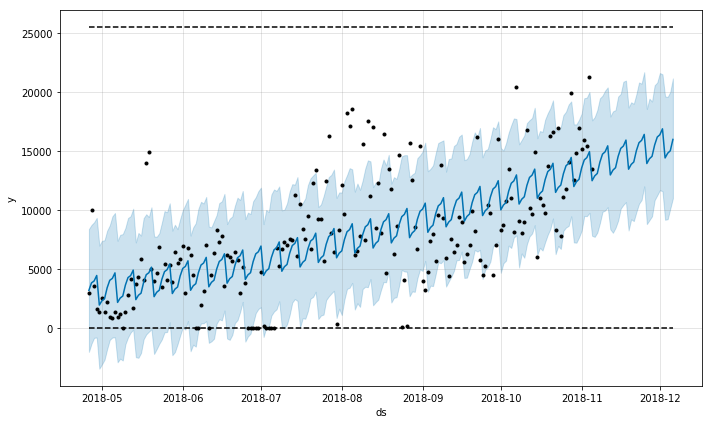

In [279]:
fb_prophet(fitbit, 'steps', 31)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse: 1.7467536709841986
Figure(720x432)


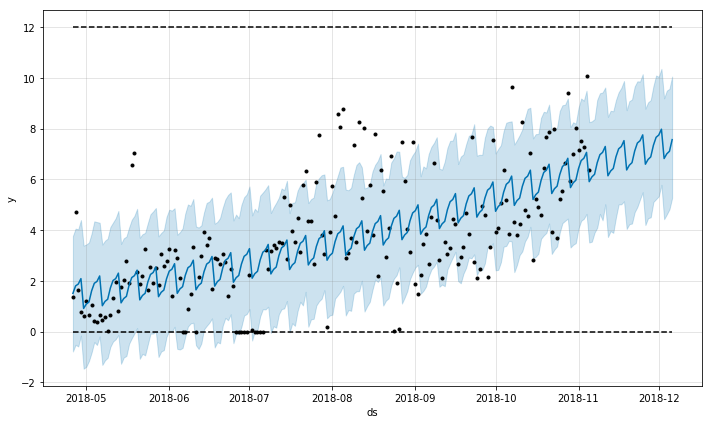

In [282]:
fb_prophet(fitbit, 'distance', 31)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse: 94.09398184450926
Figure(720x432)


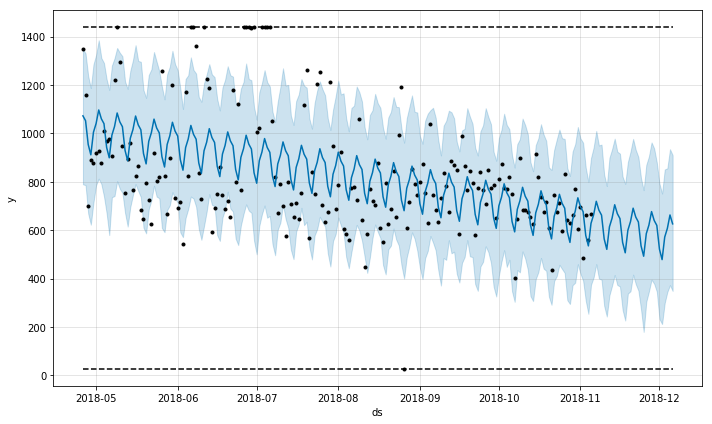

In [283]:
fb_prophet(fitbit, 'minutes_sedentary', 31)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse: 91.77936376388335
Figure(720x432)


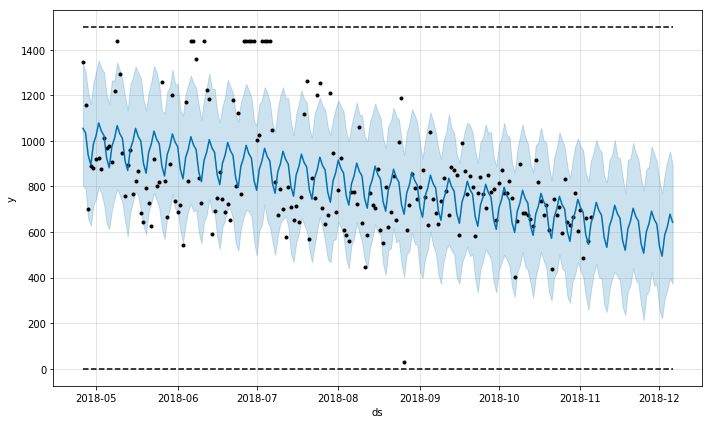

In [276]:
# fb_prophet(fitbit, 'minutes_sedentary', 0, 1500, 31)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse: 411.22684266598196
Figure(720x432)


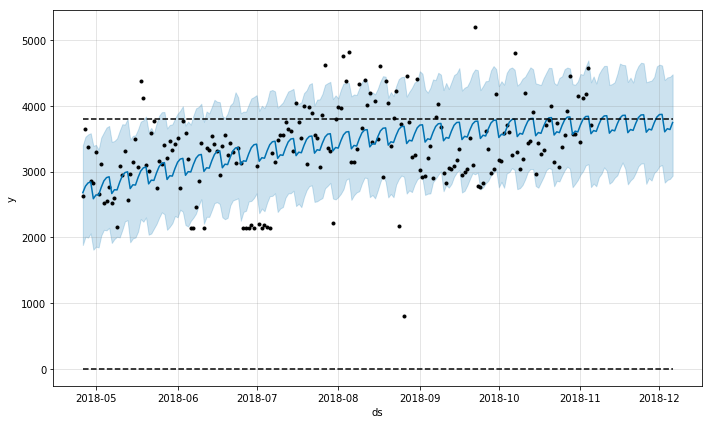

In [277]:
fb_prophet(fitbit, 'calories_burned', 0, 3800, 31)

In [325]:
def fb_prophet_all(df, periods):
    feats_predict = ['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories']   
    for feat in feats_predict:
    
        variable = df[feat]
        train = variable[:194]
        test = variable[194:225]
        to_predict = variable[225:]
        train_df = train.to_frame()
        train_df.reset_index(inplace=True)
        train_df.rename(index=str, columns={'date':'ds'}, inplace=True)
        train_df.rename(index=str, columns={feat:'y'}, inplace=True)

        train_df['cap'] = max(df[feat])
        train_df['floor'] = min(df[feat])

        m = Prophet(growth='logistic', changepoint_range=0.9)
        m.fit(train_df)

        future = m.make_future_dataframe(periods=periods)
        future['cap'] = max(df[feat])
        future['floor'] = min(df[feat])

        forecast = m.predict(future)
        forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)

        test_df = test.to_frame()
        forecast_df.set_index('ds', inplace=True)
        forecast_df = forecast_df.join(test_df)
        forecast_df.yhat = forecast_df.yhat.astype(int)
        forecast_df['error'] = forecast_df[feat] - forecast_df['yhat']
        forecast_df['abs_error'] = abs(forecast_df['error'])
        forecast_df['sqr_error'] = forecast_df['abs_error'] ** 2
        rmse = (forecast_df.sqr_error.sum()/forecast_df.shape[0]) ** .5 
        print(str(feat) + ':')
        print('rmse: ' + str(rmse))
        print(str(feat) + ':')
        print(forecast_df.head(3))
        print(str(feat) + ':')
        print(forecast_df.tail(3))
        print(str(feat) + ':')
        print(m.plot(forecast))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


calories_burned:
rmse: 422.753073661591
calories_burned:
            yhat   yhat_lower   yhat_upper  calories_burned  error  abs_error  \
ds                                                                              
2018-11-06  3675  2892.438749  4441.427639           3801.0  126.0      126.0   
2018-11-07  3665  2934.620440  4449.081600           3681.0   16.0       16.0   
2018-11-08  3774  3022.971277  4578.078450           4137.0  363.0      363.0   

            sqr_error  
ds                     
2018-11-06    15876.0  
2018-11-07      256.0  
2018-11-08   131769.0  
calories_burned:
            yhat   yhat_lower   yhat_upper  calories_burned  error  abs_error  \
ds                                                                              
2018-12-04  3786  2976.596919  4502.181682           3384.0 -402.0      402.0   
2018-12-05  3775  3014.445845  4516.931785           3670.0 -105.0      105.0   
2018-12-06  3884  3107.723681  4687.366191           3669.0 -215.0      215.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


steps:
rmse: 3937.8585755827144
steps:
             yhat   yhat_lower    yhat_upper    steps   error  abs_error  \
ds                                                                         
2018-11-06  12889  8012.686756  17814.102492  14300.0  1411.0     1411.0   
2018-11-07  13099  7807.776746  17765.135458  13664.0   565.0      565.0   
2018-11-08  14062  9121.449393  18618.373419  15542.0  1480.0     1480.0   

            sqr_error  
ds                     
2018-11-06  1990921.0  
2018-11-07   319225.0  
2018-11-08  2190400.0  
steps:
             yhat    yhat_lower    yhat_upper    steps   error  abs_error  \
ds                                                                          
2018-12-04  14815  10021.760928  20115.028511  13763.0 -1052.0     1052.0   
2018-12-05  15022   9845.417618  19744.276338  13865.0 -1157.0     1157.0   
2018-12-06  15982  10791.275979  21153.342699  14774.0 -1208.0     1208.0   

            sqr_error  
ds                     
2018-12-04  1106704

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


distance:
rmse: 1.7467536709841986
distance:
            yhat  yhat_lower  yhat_upper  distance  error  abs_error  \
ds                                                                     
2018-11-06     6    3.637651    8.499587      6.74   0.74       0.74   
2018-11-07     6    3.747297    8.681355      6.46   0.46       0.46   
2018-11-08     6    4.147881    9.046945      7.33   1.33       1.33   

            sqr_error  
ds                     
2018-11-06     0.5476  
2018-11-07     0.2116  
2018-11-08     1.7689  
distance:
            yhat  yhat_lower  yhat_upper  distance  error  abs_error  \
ds                                                                     
2018-12-04     7    4.761141    9.298994      6.49  -0.51       0.51   
2018-12-05     7    4.829269    9.473970      6.52  -0.48       0.48   
2018-12-06     7    5.119632    9.769706      6.96  -0.04       0.04   

            sqr_error  
ds                     
2018-12-04     0.2601  
2018-12-05     0.2304  
2018-12

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


floors:
rmse: 47.69053466647437
floors:
            yhat  yhat_lower  yhat_upper  floors  error  abs_error  sqr_error
ds                                                                           
2018-11-06    17   -6.782316   42.253107    16.0   -1.0        1.0        1.0
2018-11-07    18   -6.044047   39.387226     9.0   -9.0        9.0       81.0
2018-11-08    13  -10.363387   36.866940    26.0   13.0       13.0      169.0
floors:
            yhat  yhat_lower  yhat_upper  floors  error  abs_error  sqr_error
ds                                                                           
2018-12-04    20   -1.637237   44.928848    13.0   -7.0        7.0       49.0
2018-12-05    20   -2.001844   45.479019    12.0   -8.0        8.0       64.0
2018-12-06    16   -6.510566   38.747187     9.0   -7.0        7.0       49.0
floors:
Figure(720x432)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_sedentary:
rmse: 94.09398184450926
minutes_sedentary:
            yhat  yhat_lower   yhat_upper  minutes_sedentary  error  \
ds                                                                    
2018-11-06   664  402.339853   951.124148              659.0   -5.0   
2018-11-07   719  431.394782  1000.601350              566.0 -153.0   
2018-11-08   683  422.533519   960.602938              716.0   33.0   

            abs_error  sqr_error  
ds                                
2018-11-06        5.0       25.0  
2018-11-07      153.0    23409.0  
2018-11-08       33.0     1089.0  
minutes_sedentary:
            yhat  yhat_lower  yhat_upper  minutes_sedentary  error  abs_error  \
ds                                                                              
2018-12-04   607  363.826087  901.870569              608.0    1.0        1.0   
2018-12-05   663  390.115698  926.711738              739.0   76.0       76.0   
2018-12-06   626  354.924742  891.777590              647.0   21

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_lightly_active:
rmse: 54.07581297019118
minutes_lightly_active:
            yhat  yhat_lower  yhat_upper  minutes_lightly_active  error  \
ds                                                                        
2018-11-06   205  111.232222  293.638164                   176.0  -29.0   
2018-11-07   191  104.586979  284.156322                   172.0  -19.0   
2018-11-08   211  126.006306  307.358873                   238.0   27.0   

            abs_error  sqr_error  
ds                                
2018-11-06       29.0      841.0  
2018-11-07       19.0      361.0  
2018-11-08       27.0      729.0  
minutes_lightly_active:
            yhat  yhat_lower  yhat_upper  minutes_lightly_active  error  \
ds                                                                        
2018-12-04   213  126.415631  304.429182                   199.0  -14.0   
2018-12-05   199  113.613741  289.286716                   200.0    1.0   
2018-12-06   219  128.858852  309.932344             

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_fairly_active:
rmse: 20.7815054253039
minutes_fairly_active:
            yhat  yhat_lower  yhat_upper  minutes_fairly_active  error  \
ds                                                                       
2018-11-06    24    4.875986   45.407483                    7.0  -17.0   
2018-11-07    26    5.685429   46.898308                    4.0  -22.0   
2018-11-08    26    5.975414   45.651236                   15.0  -11.0   

            abs_error  sqr_error  
ds                                
2018-11-06       17.0      289.0  
2018-11-07       22.0      484.0  
2018-11-08       11.0      121.0  
minutes_fairly_active:
            yhat  yhat_lower  yhat_upper  minutes_fairly_active  error  \
ds                                                                       
2018-12-04    32   12.419107   53.959542                   11.0  -21.0   
2018-12-05    35   14.667497   54.064185                   12.0  -23.0   
2018-12-06    35   15.427744   55.192489                    4.0  -

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_very_active:
rmse: 51.24482664683837
minutes_very_active:
            yhat  yhat_lower  yhat_upper  minutes_very_active  error  \
ds                                                                     
2018-11-06    76   40.082127  113.761683                 88.0   12.0   
2018-11-07    79   39.655721  117.654296                 82.0    3.0   
2018-11-08    83   44.113304  123.889762                 86.0    3.0   

            abs_error  sqr_error  
ds                                
2018-11-06       12.0      144.0  
2018-11-07        3.0        9.0  
2018-11-08        3.0        9.0  
minutes_very_active:
            yhat  yhat_lower  yhat_upper  minutes_very_active  error  \
ds                                                                     
2018-12-04   100   61.640186  139.245014                 67.0  -33.0   
2018-12-05   104   66.599213  141.350794                 69.0  -35.0   
2018-12-06   108   68.272044  146.585637                 78.0  -30.0   

            abs_

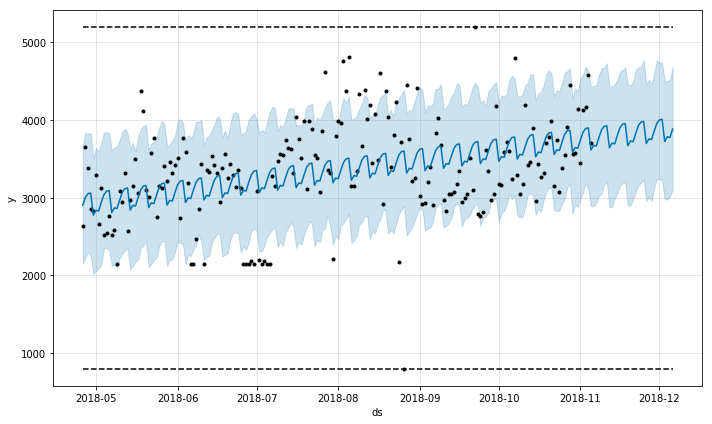

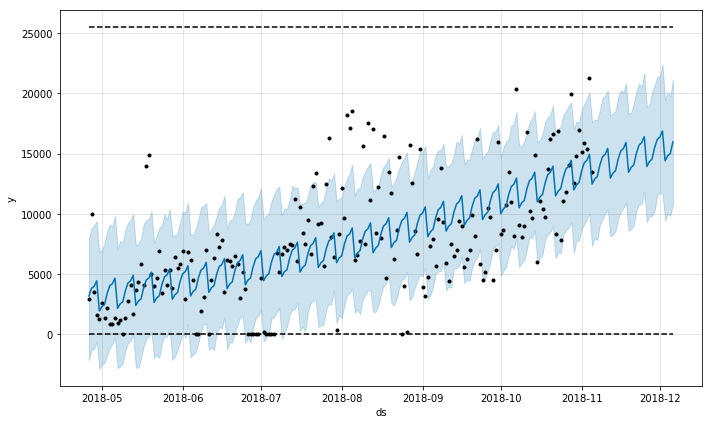

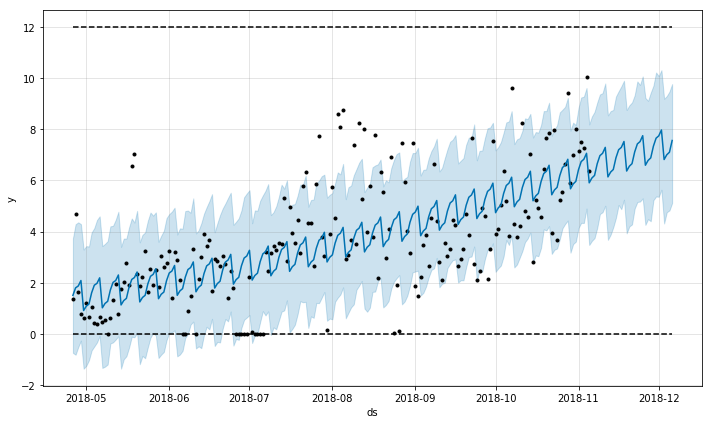

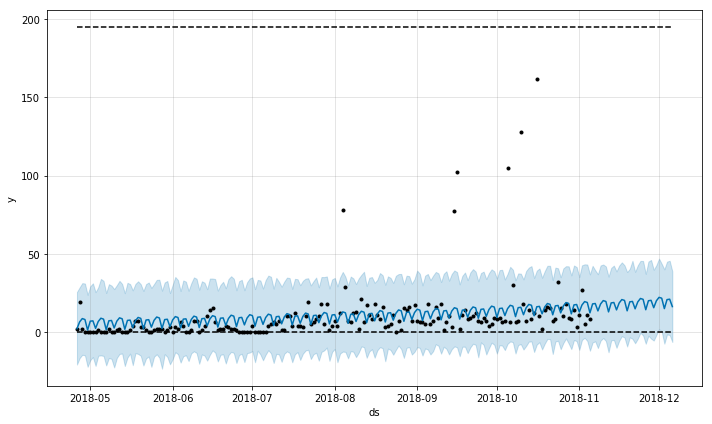

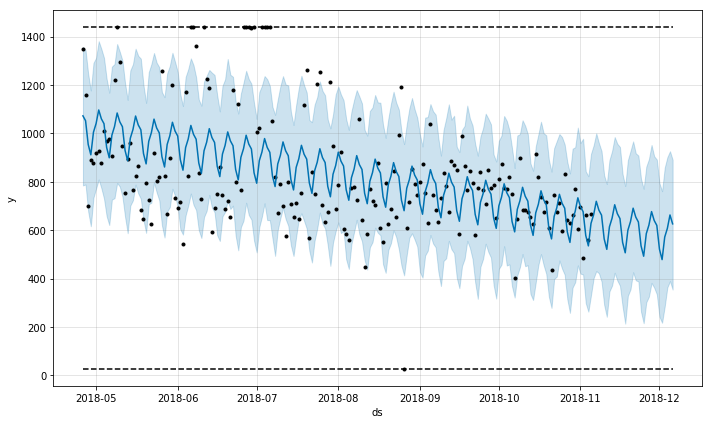

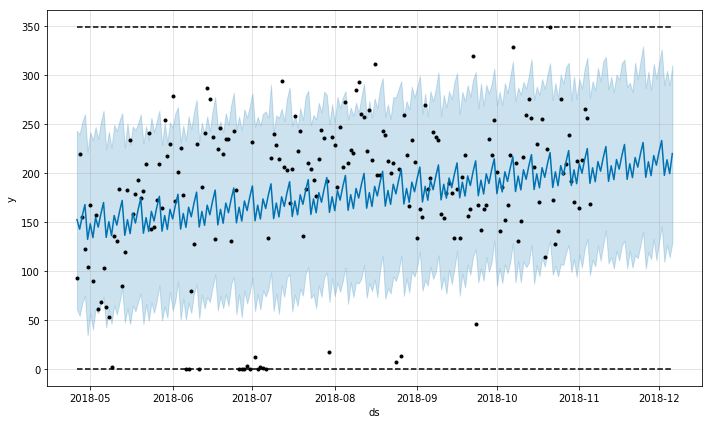

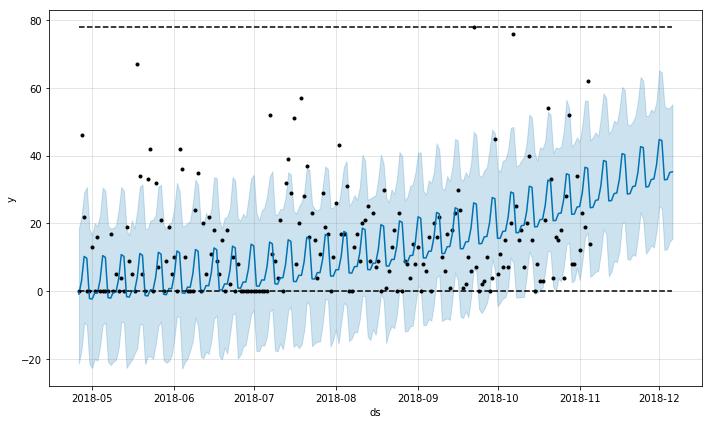

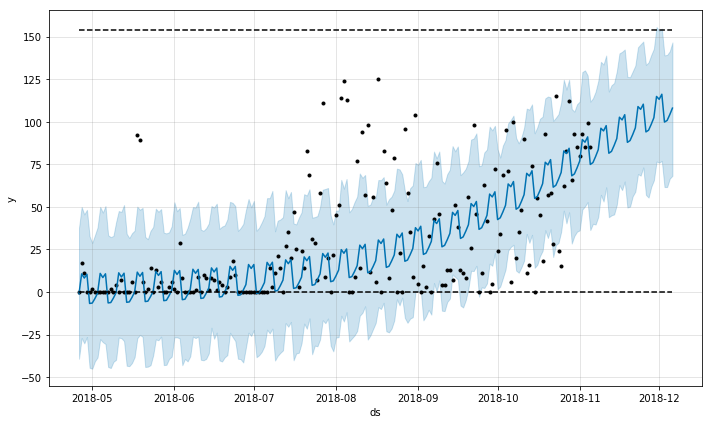

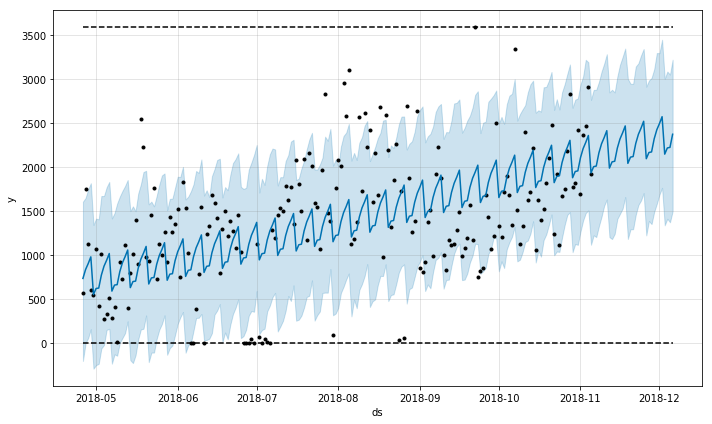

In [494]:
fb_prophet_all(fitbit, 31)

In [414]:
fitbit.drop(columns='calories_in', inplace=True)
fitbit['total_minutes'] = fitbit.minutes_sedentary + fitbit.minutes_fairly_active +\
                          fitbit.minutes_lightly_active + fitbit.minutes_very_active
    


In [415]:

fitbit['hours_awake'] = fitbit.total_minutes/60
fitbit['hours_asleep'] = 24 - fitbit.hours_awake

In [416]:
no_outliers = fitbit[fitbit.steps > 1000]

no_outliers.loc[no_outliers.hours_awake == 24, 'minutes_sedentary'] = no_outliers.minutes_sedentary.mean()

no_outliers['total_minutes'] = no_outliers.minutes_sedentary + no_outliers.minutes_fairly_active +\
             no_outliers.minutes_lightly_active + no_outliers.minutes_very_active

no_outliers['hours_awake'] = no_outliers.total_minutes/60
no_outliers['hours_asleep'] = 24 - no_outliers.hours_awake

In [394]:
no_outliers.shape

(205, 21)

In [324]:
def fb_prophet_all_no_outliers(df, periods):
    feats_predict = ['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories']   
    for feat in feats_predict:
    
        variable = df[feat]
        train = variable[:174]
        test = variable[174:205]
        to_predict = variable[205:]
        train_df = train.to_frame()
        train_df.reset_index(inplace=True)
        train_df.rename(index=str, columns={'date':'ds'}, inplace=True)
        train_df.rename(index=str, columns={feat:'y'}, inplace=True)

        train_df['cap'] = max(df[feat])
        train_df['floor'] = min(df[feat])

        m = Prophet(growth='logistic', changepoint_range=0.9)
        m.fit(train_df)

        future = m.make_future_dataframe(periods=periods)
        future['cap'] = max(df[feat])
        future['floor'] = min(df[feat])

        forecast = m.predict(future)
        forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)

        test_df = test.to_frame()
        forecast_df.set_index('ds', inplace=True)
        forecast_df = forecast_df.join(test_df)
        forecast_df.yhat = forecast_df.yhat.astype(int)
        forecast_df['error'] = forecast_df[feat] - forecast_df['yhat']
        forecast_df['abs_error'] = abs(forecast_df['error'])
        forecast_df['sqr_error'] = forecast_df['abs_error'] ** 2
        rmse = (forecast_df.sqr_error.sum()/forecast_df.shape[0]) ** .5 
        print(str(feat) + ':')
        print('rmse: ' + str(rmse))
        print(str(feat) + ':')
        print(forecast_df.head(3))
        print(str(feat) + ':')
        print(forecast_df.tail(3))
        print(str(feat) + ':')
        print(m.plot(forecast))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


calories_burned:
rmse: 432.6849408802161
calories_burned:
            yhat   yhat_lower   yhat_upper  calories_burned  error  abs_error  \
ds                                                                              
2018-11-06  3655  3015.100462  4260.483315           3801.0  146.0      146.0   
2018-11-07  3729  3121.737427  4397.943937           3681.0  -48.0       48.0   
2018-11-08  3797  3185.845348  4415.749103           4137.0  340.0      340.0   

            sqr_error  
ds                     
2018-11-06    21316.0  
2018-11-07     2304.0  
2018-11-08   115600.0  
calories_burned:
            yhat   yhat_lower   yhat_upper  calories_burned  error  abs_error  \
ds                                                                              
2018-12-04  3745  3130.043642  4392.156146           3384.0 -361.0      361.0   
2018-12-05  3819  3206.512792  4424.040657           3670.0 -149.0      149.0   
2018-12-06  3887  3244.996980  4478.659639           3669.0 -218.0      218

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


steps:
rmse: 3913.1511268970285
steps:
             yhat   yhat_lower    yhat_upper    steps   error  abs_error  \
ds                                                                         
2018-11-06  12517  7765.858828  17486.809812  14300.0  1783.0     1783.0   
2018-11-07  13106  8365.863697  17883.487330  13664.0   558.0      558.0   
2018-11-08  13927  9130.930667  18547.269098  15542.0  1615.0     1615.0   

            sqr_error  
ds                     
2018-11-06  3179089.0  
2018-11-07   311364.0  
2018-11-08  2608225.0  
steps:
             yhat    yhat_lower    yhat_upper    steps  error  abs_error  \
ds                                                                         
2018-12-04  14209   9439.244744  18840.279865  13763.0 -446.0      446.0   
2018-12-05  14797   9941.546646  19333.194059  13865.0 -932.0      932.0   
2018-12-06  15616  11020.278360  20116.021239  14774.0 -842.0      842.0   

            sqr_error  
ds                     
2018-12-04   198916.0  


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


distance:
rmse: 1.8865021395642902
distance:
            yhat  yhat_lower  yhat_upper  distance  error  abs_error  \
ds                                                                     
2018-11-06     5    3.643263    7.976942      6.74   1.74       1.74   
2018-11-07     6    3.974348    8.233890      6.46   0.46       0.46   
2018-11-08     6    4.300719    8.593472      7.33   1.33       1.33   

            sqr_error  
ds                     
2018-11-06     3.0276  
2018-11-07     0.2116  
2018-11-08     1.7689  
distance:
            yhat  yhat_lower  yhat_upper  distance  error  abs_error  \
ds                                                                     
2018-12-04     6    4.511628    8.733428      6.49   0.49       0.49   
2018-12-05     6    4.689330    8.945473      6.52   0.52       0.52   
2018-12-06     7    5.174021    9.459131      6.96  -0.04       0.04   

            sqr_error  
ds                     
2018-12-04     0.2401  
2018-12-05     0.2704  
2018-12

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


floors:
rmse: 47.52961725207802
floors:
            yhat  yhat_lower  yhat_upper  floors  error  abs_error  sqr_error
ds                                                                           
2018-11-06    19   -7.740198   43.836622    16.0   -3.0        3.0        9.0
2018-11-07    20   -3.483902   46.379918     9.0  -11.0       11.0      121.0
2018-11-08    14   -9.551089   37.735978    26.0   12.0       12.0      144.0
floors:
            yhat  yhat_lower  yhat_upper  floors  error  abs_error  sqr_error
ds                                                                           
2018-12-04    22   -0.566661   46.233147    13.0   -9.0        9.0       81.0
2018-12-05    23   -1.577472   47.033312    12.0  -11.0       11.0      121.0
2018-12-06    17   -6.333487   41.923041     9.0   -8.0        8.0       64.0
floors:
Figure(720x432)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_sedentary:
rmse: 116.26041403232547
minutes_sedentary:
            yhat  yhat_lower  yhat_upper  minutes_sedentary  error  abs_error  \
ds                                                                              
2018-11-06   740  581.389775  897.535555              659.0  -81.0       81.0   
2018-11-07   731  583.537246  875.222845              566.0 -165.0      165.0   
2018-11-08   711  556.258973  857.321731              716.0    5.0        5.0   

            sqr_error  
ds                     
2018-11-06     6561.0  
2018-11-07    27225.0  
2018-11-08       25.0  
minutes_sedentary:
            yhat  yhat_lower  yhat_upper  minutes_sedentary  error  abs_error  \
ds                                                                              
2018-12-04   729  582.234487  897.336048              608.0 -121.0      121.0   
2018-12-05   720  565.316123  866.450605              739.0   19.0       19.0   
2018-12-06   700  544.102352  856.654907              647.0  -53.0  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_lightly_active:
rmse: 46.59710637561785
minutes_lightly_active:
            yhat  yhat_lower  yhat_upper  minutes_lightly_active  error  \
ds                                                                        
2018-11-06   222  161.987333  284.709788                   176.0  -46.0   
2018-11-07   221  155.740971  289.528470                   172.0  -49.0   
2018-11-08   236  172.626508  296.549687                   238.0    2.0   

            abs_error  sqr_error  
ds                                
2018-11-06       46.0     2116.0  
2018-11-07       49.0     2401.0  
2018-11-08        2.0        4.0  
minutes_lightly_active:
            yhat  yhat_lower  yhat_upper  minutes_lightly_active  error  \
ds                                                                        
2018-12-04   229  167.090505  294.265142                   199.0  -30.0   
2018-12-05   228  159.264308  294.780961                   200.0  -28.0   
2018-12-06   243  180.955720  304.975030             

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_fairly_active:
rmse: 21.403195420159776
minutes_fairly_active:
            yhat  yhat_lower  yhat_upper  minutes_fairly_active  error  \
ds                                                                       
2018-11-06    25    3.017807   46.057225                    7.0  -18.0   
2018-11-07    27    5.751354   48.995730                    4.0  -23.0   
2018-11-08    27    6.499103   48.934051                   15.0  -12.0   

            abs_error  sqr_error  
ds                                
2018-11-06       18.0      324.0  
2018-11-07       23.0      529.0  
2018-11-08       12.0      144.0  
minutes_fairly_active:
            yhat  yhat_lower  yhat_upper  minutes_fairly_active  error  \
ds                                                                       
2018-12-04    33   13.050425   54.163131                   11.0  -22.0   
2018-12-05    35   16.017087   57.018043                   12.0  -23.0   
2018-12-06    35   16.031210   55.295842                    4.0 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_very_active:
rmse: 52.395210320373074
minutes_very_active:
            yhat  yhat_lower  yhat_upper  minutes_very_active  error  \
ds                                                                     
2018-11-06    77   36.250071  116.378209                 88.0   11.0   
2018-11-07    80   41.228957  118.920278                 82.0    2.0   
2018-11-08    84   43.815351  124.787857                 86.0    2.0   

            abs_error  sqr_error  
ds                                
2018-11-06       11.0      121.0  
2018-11-07        2.0        4.0  
2018-11-08        2.0        4.0  
minutes_very_active:
            yhat  yhat_lower  yhat_upper  minutes_very_active  error  \
ds                                                                     
2018-12-04   101   60.924229  141.578881                 67.0  -34.0   
2018-12-05   104   65.282538  145.010288                 69.0  -35.0   
2018-12-06   109   68.863675  151.146071                 78.0  -31.0   

            abs

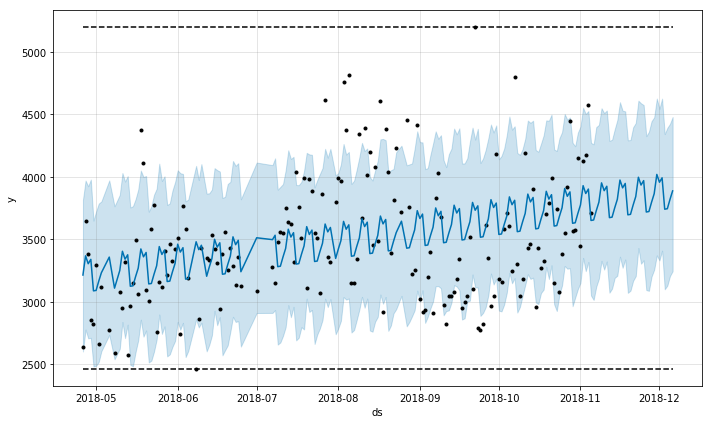

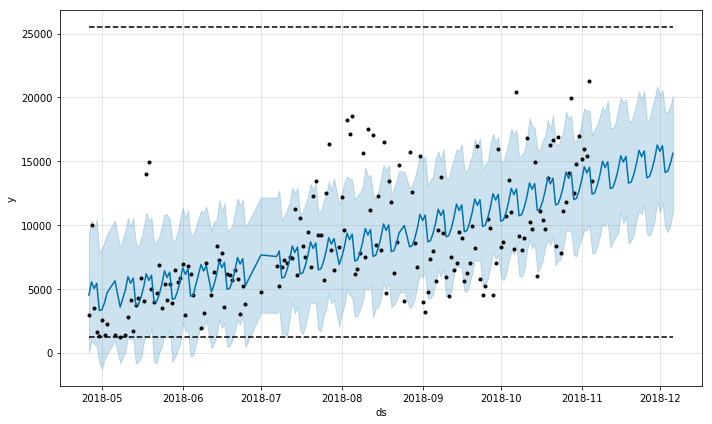

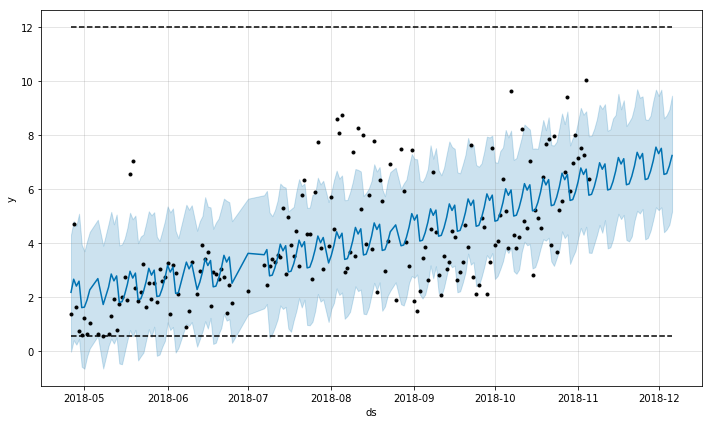

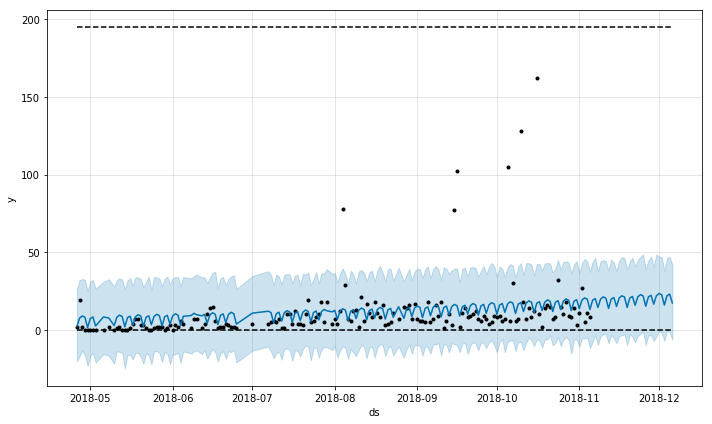

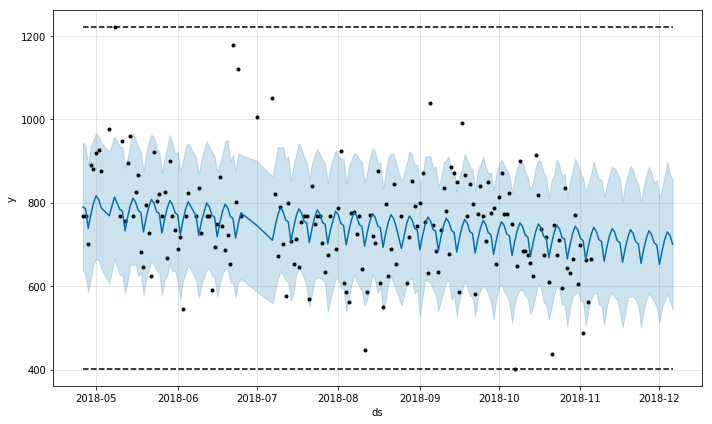

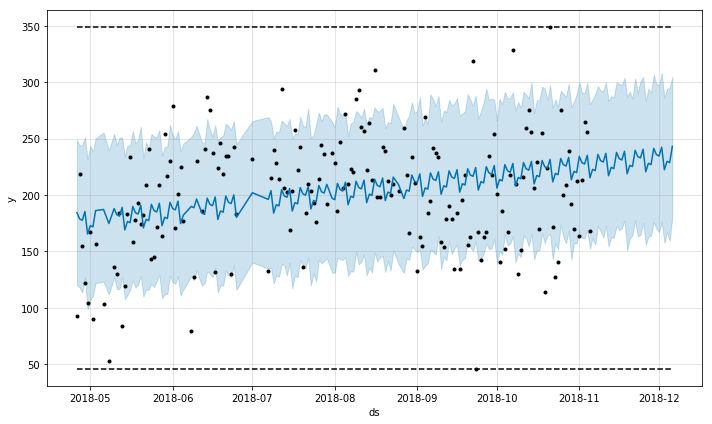

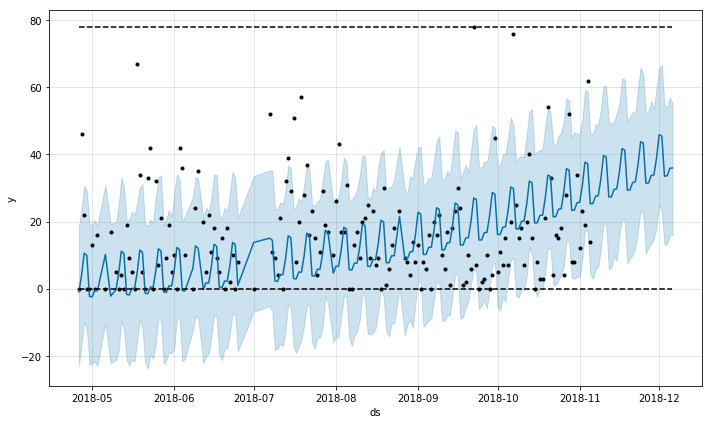

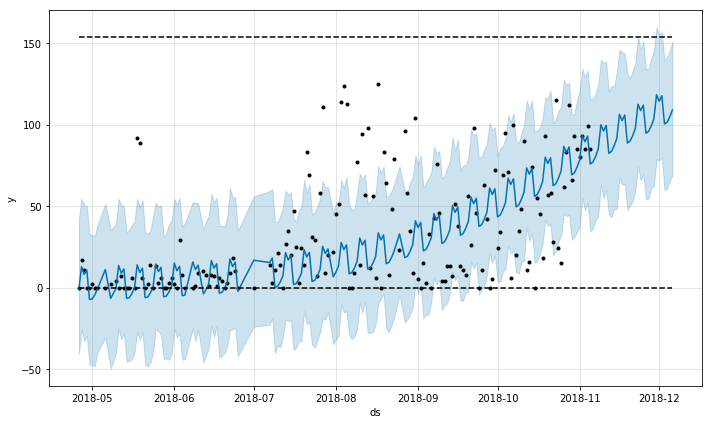

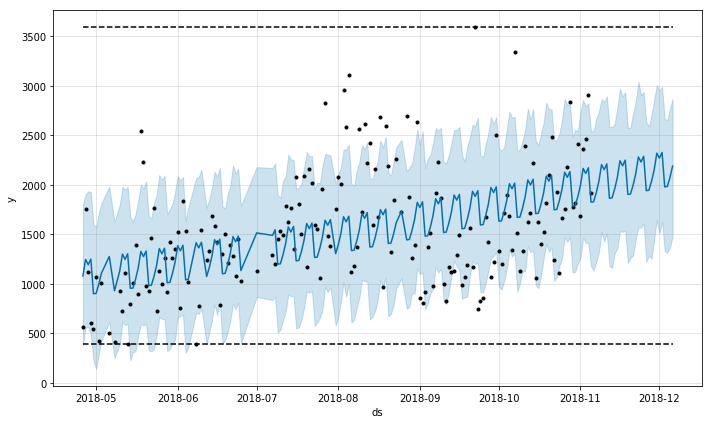

In [328]:
fb_prophet_all_no_outliers(no_outliers, 31)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


calories_burned:
rmse: 422.753073661591
calories_burned:
            yhat   yhat_lower   yhat_upper  calories_burned  error  abs_error  \
ds                                                                              
2018-11-06  3675  2909.683271  4454.234555           3801.0  126.0      126.0   
2018-11-07  3665  2919.233961  4456.047534           3681.0   16.0       16.0   
2018-11-08  3774  2968.748359  4566.800315           4137.0  363.0      363.0   

            sqr_error  
ds                     
2018-11-06    15876.0  
2018-11-07      256.0  
2018-11-08   131769.0  
calories_burned:
            yhat   yhat_lower   yhat_upper  calories_burned  error  abs_error  \
ds                                                                              
2018-12-04  3786  3056.641716  4515.654894           3384.0 -402.0      402.0   
2018-12-05  3775  2984.562229  4542.783424           3670.0 -105.0      105.0   
2018-12-06  3884  3122.417883  4623.412324           3669.0 -215.0      215.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


steps:
rmse: 3937.8585755827144
steps:
             yhat   yhat_lower    yhat_upper    steps   error  abs_error  \
ds                                                                         
2018-11-06  12889  7927.440491  17630.206906  14300.0  1411.0     1411.0   
2018-11-07  13099  7957.937139  18192.814892  13664.0   565.0      565.0   
2018-11-08  14062  8850.202549  18801.776770  15542.0  1480.0     1480.0   

            sqr_error  
ds                     
2018-11-06  1990921.0  
2018-11-07   319225.0  
2018-11-08  2190400.0  
steps:
             yhat    yhat_lower    yhat_upper    steps   error  abs_error  \
ds                                                                          
2018-12-04  14815   9593.059502  19999.430910  13763.0 -1052.0     1052.0   
2018-12-05  15022  10105.569840  20180.029015  13865.0 -1157.0     1157.0   
2018-12-06  15982  11115.882072  20743.084199  14774.0 -1208.0     1208.0   

            sqr_error  
ds                     
2018-12-04  1106704

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


distance:
rmse: 1.7467536709841986
distance:
            yhat  yhat_lower  yhat_upper  distance  error  abs_error  \
ds                                                                     
2018-11-06     6    3.784099    8.461136      6.74   0.74       0.74   
2018-11-07     6    3.752328    8.599004      6.46   0.46       0.46   
2018-11-08     6    4.294907    9.100170      7.33   1.33       1.33   

            sqr_error  
ds                     
2018-11-06     0.5476  
2018-11-07     0.2116  
2018-11-08     1.7689  
distance:
            yhat  yhat_lower  yhat_upper  distance  error  abs_error  \
ds                                                                     
2018-12-04     7    4.848130    9.549942      6.49  -0.51       0.51   
2018-12-05     7    4.796443    9.464933      6.52  -0.48       0.48   
2018-12-06     7    5.177037   10.018894      6.96  -0.04       0.04   

            sqr_error  
ds                     
2018-12-04     0.2601  
2018-12-05     0.2304  
2018-12

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


floors:
rmse: 47.69053466647437
floors:
            yhat  yhat_lower  yhat_upper  floors  error  abs_error  sqr_error
ds                                                                           
2018-11-06    17   -6.070952   41.715990    16.0   -1.0        1.0        1.0
2018-11-07    18   -6.122234   42.641992     9.0   -9.0        9.0       81.0
2018-11-08    13  -11.077033   36.421093    26.0   13.0       13.0      169.0
floors:
            yhat  yhat_lower  yhat_upper  floors  error  abs_error  sqr_error
ds                                                                           
2018-12-04    20   -1.281381   45.844783    13.0   -7.0        7.0       49.0
2018-12-05    20   -3.101858   45.785163    12.0   -8.0        8.0       64.0
2018-12-06    16   -6.903164   39.567225     9.0   -7.0        7.0       49.0
floors:
Figure(720x432)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_sedentary:
rmse: 94.09398184450926
minutes_sedentary:
            yhat  yhat_lower  yhat_upper  minutes_sedentary  error  abs_error  \
ds                                                                              
2018-11-06   664  382.738798  937.865035              659.0   -5.0        5.0   
2018-11-07   719  447.114649  995.416240              566.0 -153.0      153.0   
2018-11-08   683  400.085894  949.945100              716.0   33.0       33.0   

            sqr_error  
ds                     
2018-11-06       25.0  
2018-11-07    23409.0  
2018-11-08     1089.0  
minutes_sedentary:
            yhat  yhat_lower  yhat_upper  minutes_sedentary  error  abs_error  \
ds                                                                              
2018-12-04   607  327.288143  878.725235              608.0    1.0        1.0   
2018-12-05   663  377.726752  943.706399              739.0   76.0       76.0   
2018-12-06   626  350.987524  905.996616              647.0   21.0   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_lightly_active:
rmse: 54.07581297019118
minutes_lightly_active:
            yhat  yhat_lower  yhat_upper  minutes_lightly_active  error  \
ds                                                                        
2018-11-06   205  114.051303  296.175663                   176.0  -29.0   
2018-11-07   191   96.445330  284.217190                   172.0  -19.0   
2018-11-08   211  122.006500  301.588458                   238.0   27.0   

            abs_error  sqr_error  
ds                                
2018-11-06       29.0      841.0  
2018-11-07       19.0      361.0  
2018-11-08       27.0      729.0  
minutes_lightly_active:
            yhat  yhat_lower  yhat_upper  minutes_lightly_active  error  \
ds                                                                        
2018-12-04   213  125.615139  303.530912                   199.0  -14.0   
2018-12-05   199  112.631907  297.508113                   200.0    1.0   
2018-12-06   219  124.865656  308.219266             

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_fairly_active:
rmse: 20.7815054253039
minutes_fairly_active:
            yhat  yhat_lower  yhat_upper  minutes_fairly_active  error  \
ds                                                                       
2018-11-06    24    5.239330   45.394518                    7.0  -17.0   
2018-11-07    26    6.069270   46.920693                    4.0  -22.0   
2018-11-08    26    7.776151   46.643535                   15.0  -11.0   

            abs_error  sqr_error  
ds                                
2018-11-06       17.0      289.0  
2018-11-07       22.0      484.0  
2018-11-08       11.0      121.0  
minutes_fairly_active:
            yhat  yhat_lower  yhat_upper  minutes_fairly_active  error  \
ds                                                                       
2018-12-04    32   13.337876   52.073664                   11.0  -21.0   
2018-12-05    35   15.282224   54.951018                   12.0  -23.0   
2018-12-06    35   16.025433   55.169825                    4.0  -

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_very_active:
rmse: 51.24482664683837
minutes_very_active:
            yhat  yhat_lower  yhat_upper  minutes_very_active  error  \
ds                                                                     
2018-11-06    76   38.609294  116.253858                 88.0   12.0   
2018-11-07    79   42.354962  117.739309                 82.0    3.0   
2018-11-08    83   43.444856  121.375357                 86.0    3.0   

            abs_error  sqr_error  
ds                                
2018-11-06       12.0      144.0  
2018-11-07        3.0        9.0  
2018-11-08        3.0        9.0  
minutes_very_active:
            yhat  yhat_lower  yhat_upper  minutes_very_active  error  \
ds                                                                     
2018-12-04   100   62.086603  141.316413                 67.0  -33.0   
2018-12-05   104   67.148882  140.806341                 69.0  -35.0   
2018-12-06   108   69.917887  147.403932                 78.0  -30.0   

            abs_

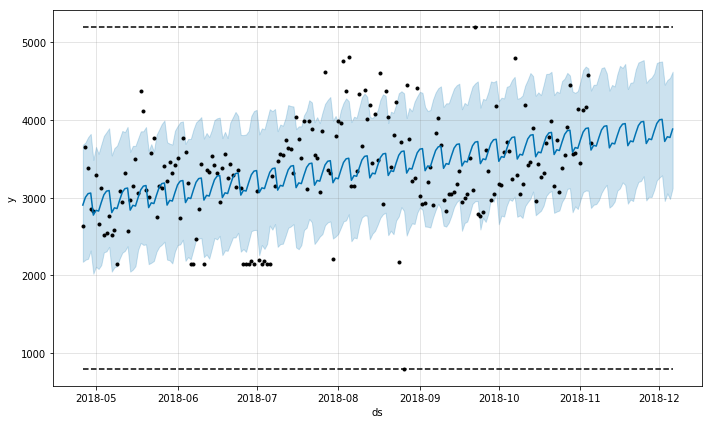

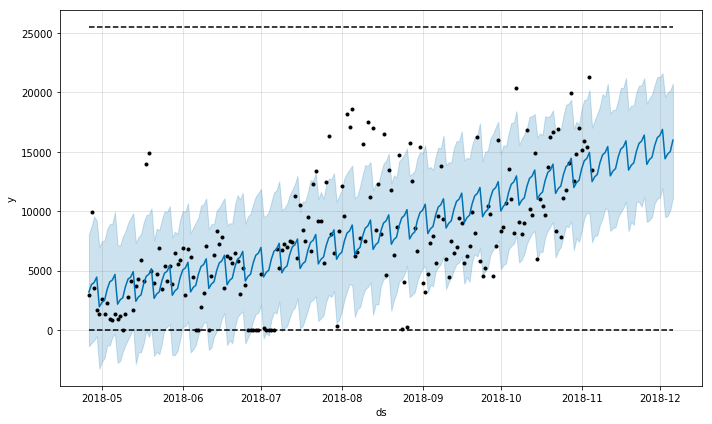

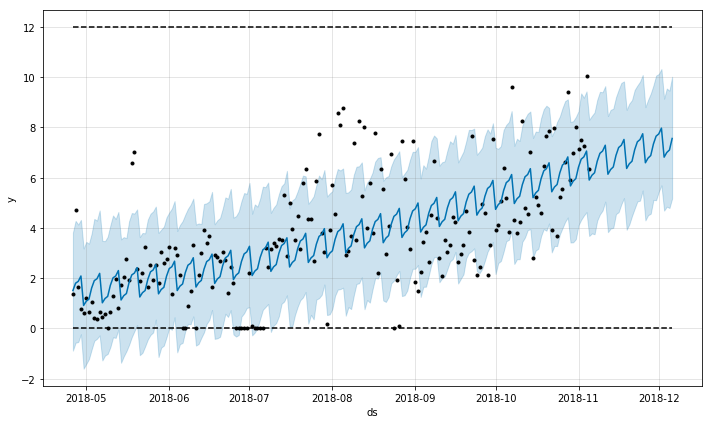

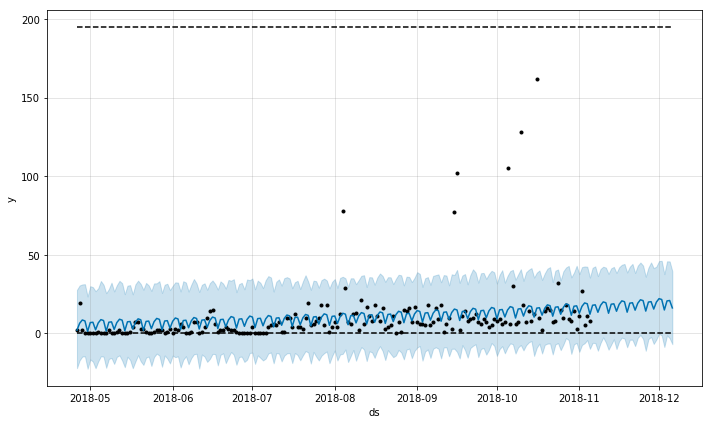

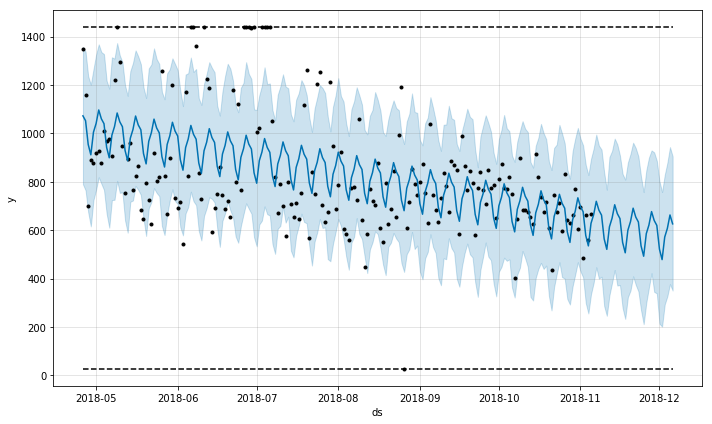

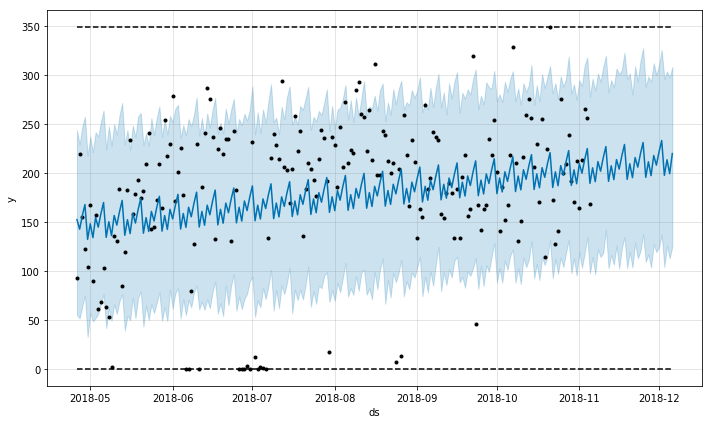

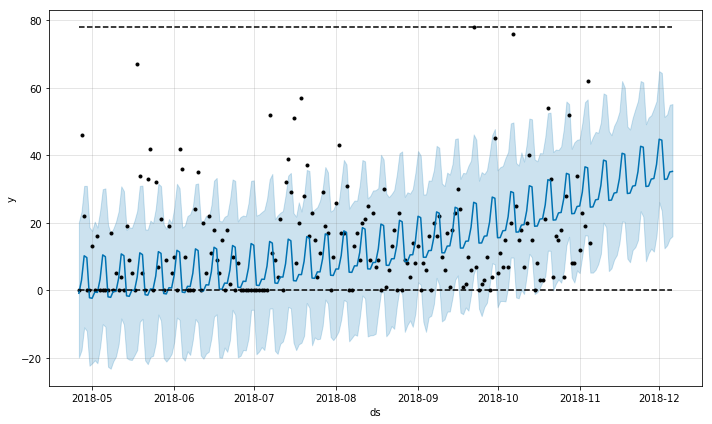

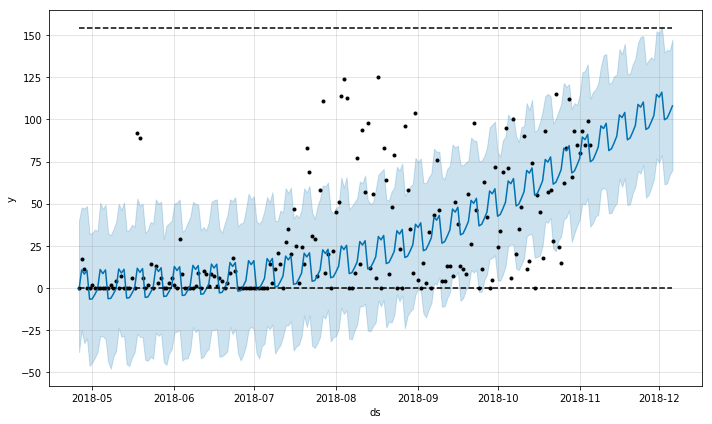

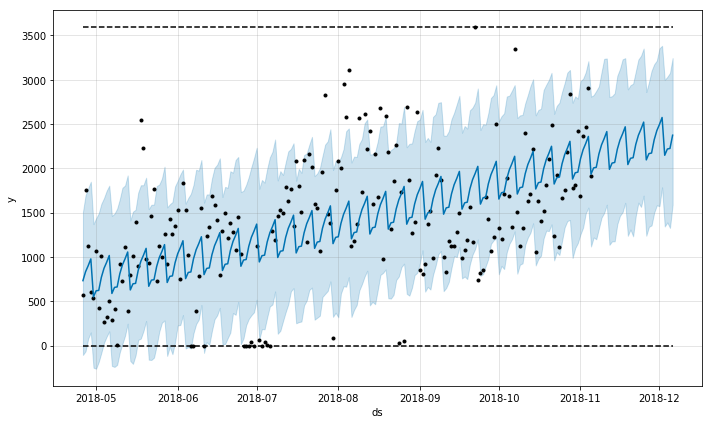

In [329]:
fb_prophet_all(fitbit, 31)

In [310]:
from sklearn.preprocessing import MinMaxScaler

In [395]:
train_s = fitbit[:194]
test_s = fitbit[194:225]

In [396]:
train_s.head(3)

calories_burned   steps  distance  floors  minutes_sedentary  \
date                                                                       
2018-04-26           2635.0  2931.0      1.38     2.0             1347.0   
2018-04-27           3649.0  9971.0      4.70    19.0             1158.0   
2018-04-28           3379.0  3521.0      1.66     2.0              702.0   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-04-26                    93.0                    0.0   
2018-04-27                   219.0                   46.0   
2018-04-28                   155.0                   22.0   

            minutes_very_active  activity_calories  calories      ...       \
date                                                              ...        
2018-04-26                  0.0              566.0       0.0      ...        
2018-04-27                 17.0             1752.0       0.0      ...        
2018-04-28                 11.0             1124.0       0.0      ...        

            fiber (g)  carbs (g)  sodium (mg)  protein (g)  water (fl oz)  \
date                                                                        
2018-04-26        0.0        0.0          0.0          0.0            0.0   
2018-04-27        0.0        0.0          0.0          0.0            0.0   
2018-04-28        0.0        0.0          0.0          0.0            0.0   

            day_of_week weekend_or_weekday total_minutes  hours_awake  \
date                                                                    
2018-04-26     Thursday            weekday        1440.0    24.000000   
2018-04-27       Friday            weekday        1440.0    24.000000   
2018-04-28     Saturday            weekend         890.0    14.833333   

            hours_asleep  
date                      
2018-04-26      0.000000  
2018-04-27      0.000000  
2018-04-28      9.166667  

[3 rows x 21 columns]

In [397]:
scaler = MinMaxScaler()
scaler.fit(train_s[['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories']])
train_s[['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories']] = scaler.transform(train_s[['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories']])
test_s[['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories']] = scaler.transform(test_s[['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories']])
train_s.head()

calories_burned     steps  distance    floors  minutes_sedentary  \
date                                                                           
2018-04-26         0.417273  0.137593  0.137313  0.012346           0.934136   
2018-04-27         0.647727  0.468078  0.467662  0.117284           0.800283   
2018-04-28         0.586364  0.165290  0.165174  0.012346           0.477337   
2018-04-29         0.466364  0.076941  0.076617  0.000000           0.611190   
2018-04-30         0.460455  0.062107  0.061692  0.000000           0.603399   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-04-26                0.266476               0.000000   
2018-04-27                0.627507               0.589744   
2018-04-28                0.444126               0.282051   
2018-04-29                0.349570               0.000000   
2018-04-30                0.297994               0.000000   

            minutes_very_active  activity_calories  calories      ...       \
date                                                              ...        
2018-04-26                0.000           0.157397       0.0      ...        
2018-04-27                0.136           0.487208       0.0      ...        
2018-04-28                0.088           0.312570       0.0      ...        
2018-04-29                0.000           0.167408       0.0      ...        
2018-04-30                0.000           0.150167       0.0      ...        

            fiber (g)  carbs (g)  sodium (mg)  protein (g)  water (fl oz)  \
date                                                                        
2018-04-26        0.0        0.0          0.0          0.0            0.0   
2018-04-27        0.0        0.0          0.0          0.0            0.0   
2018-04-28        0.0        0.0          0.0          0.0            0.0   
2018-04-29        0.0        0.0          0.0          0.0            0.0   
2018-04-30        0.0        0.0          0.0          0.0            0.0   

            day_of_week weekend_or_weekday total_minutes  hours_awake  \
date                                                                    
2018-04-26     Thursday            weekday        1440.0    24.000000   
2018-04-27       Friday            weekday        1440.0    24.000000   
2018-04-28     Saturday            weekend         890.0    14.833333   
2018-04-29       Sunday            weekend        1013.0    16.883333   
2018-04-30       Monday            weekday         984.0    16.400000   

            hours_asleep  
date                      
2018-04-26      0.000000  
2018-04-27      0.000000  
2018-04-28      9.166667  
2018-04-29      7.116667  
2018-04-30      7.600000  

[5 rows x 21 columns]

In [342]:
def plot_act_week(df):
    cols = list(df)
    for col in cols:
        monthly = df.resample('W')[col].sum()
        monthly.plot(y=col)
        plt.legend()

In [346]:
train_s = train_s[['calories_burned', 'steps', 'distance', 'floors']]  

In [348]:
train_s.head()

calories_burned     steps  distance    floors
date                                                     
2018-04-26         0.417273  0.137593  0.137313  0.012346
2018-04-27         0.647727  0.468078  0.467662  0.117284
2018-04-28         0.586364  0.165290  0.165174  0.012346
2018-04-29         0.466364  0.076941  0.076617  0.000000
2018-04-30         0.460455  0.062107  0.061692  0.000000

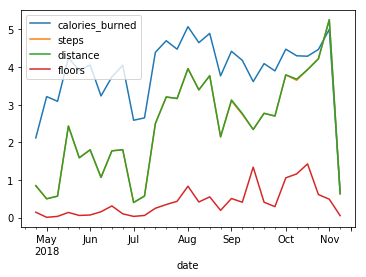

In [347]:
plot_act_week(train_s)

In [352]:
train_t = fitbit[:194]
test_t = fitbit[194:225]
train_t = train_t[['minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active']]

In [353]:
scaler = MinMaxScaler()
scaler.fit(train_t[['minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active']])
train_t[['minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active']] = scaler.transform(train_t[['minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active']])
test_t[['minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active']] = scaler.transform(test_t[['minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active']])
train_t.head()

minutes_sedentary  minutes_lightly_active  minutes_fairly_active  \
date                                                                           
2018-04-26           0.934136                0.266476               0.000000   
2018-04-27           0.800283                0.627507               0.589744   
2018-04-28           0.477337                0.444126               0.282051   
2018-04-29           0.611190                0.349570               0.000000   
2018-04-30           0.603399                0.297994               0.000000   

            minutes_very_active  
date                             
2018-04-26                0.000  
2018-04-27                0.136  
2018-04-28                0.088  
2018-04-29                0.000  
2018-04-30                0.000

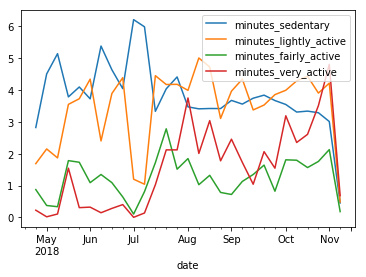

In [354]:
plot_act_week(train_t)

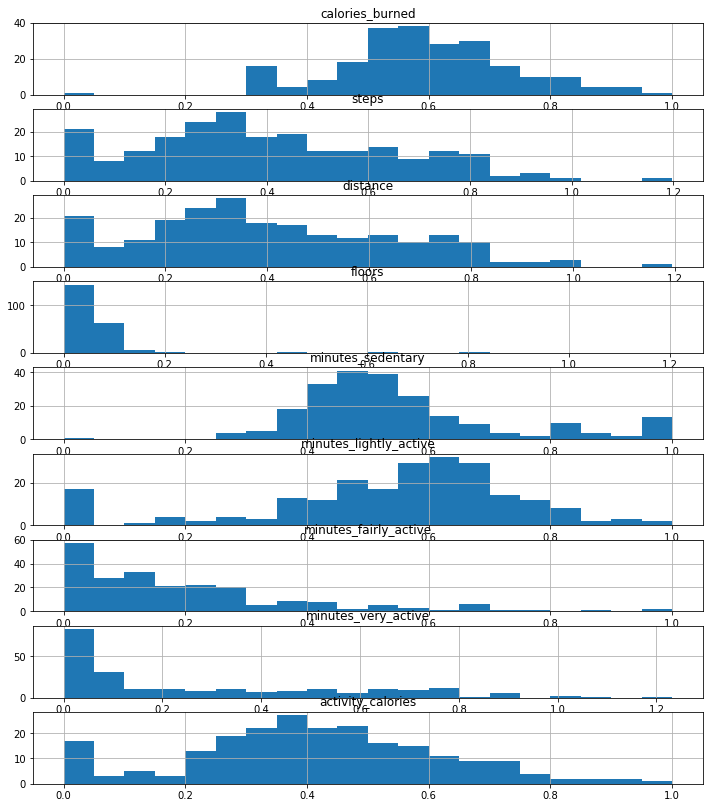

In [356]:
plt.figure(figsize=(12,14))
for i, col in enumerate(['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories']):
    plot_number = i + 1
    series = fitbit[col]
    plt.subplot(9, 1, plot_number)
    plt.title(col)
    series.hist(bins=20, density=False, cumulative=False, log=False)

In [417]:
fitbit.head(3)

calories_burned   steps  distance  floors  minutes_sedentary  \
date                                                                       
2018-04-26           2635.0  2931.0      1.38     2.0             1347.0   
2018-04-27           3649.0  9971.0      4.70    19.0             1158.0   
2018-04-28           3379.0  3521.0      1.66     2.0              702.0   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-04-26                    93.0                    0.0   
2018-04-27                   219.0                   46.0   
2018-04-28                   155.0                   22.0   

            minutes_very_active  activity_calories  calories      ...       \
date                                                              ...        
2018-04-26                  0.0              566.0       0.0      ...        
2018-04-27                 17.0             1752.0       0.0      ...        
2018-04-28                 11.0             1124.0       0.0      ...        

            fiber (g)  carbs (g)  sodium (mg)  protein (g)  water (fl oz)  \
date                                                                        
2018-04-26        0.0        0.0          0.0          0.0            0.0   
2018-04-27        0.0        0.0          0.0          0.0            0.0   
2018-04-28        0.0        0.0          0.0          0.0            0.0   

            day_of_week weekend_or_weekday total_minutes  hours_awake  \
date                                                                    
2018-04-26     Thursday            weekday        1440.0    24.000000   
2018-04-27       Friday            weekday        1440.0    24.000000   
2018-04-28     Saturday            weekend         890.0    14.833333   

            hours_asleep  
date                      
2018-04-26      0.000000  
2018-04-27      0.000000  
2018-04-28      9.166667  

[3 rows x 21 columns]

In [456]:
train_w_outliers = fitbit.calories_burned[:194].to_frame()
test_w_outliers = fitbit.calories_burned[194:225].to_frame()

In [457]:
cal_train = train_w_outliers[['calories_burned']]
cal_test = test_w_outliers[['calories_burned']]
# cal_train.to_frame()
# cal_test.to_frame()
cal_train.reset_index(inplace=True)
cal_train.rename(index=str, columns={'date':'ds'}, inplace=True)
cal_train.rename(index=str, columns={'calories_burned':'y'}, inplace=True)
# print('One')
cal_train['cap'] = max(cal_train['y'])
cal_train['floor'] = min(cal_train['y'])
# print(cal_train.head(3))

# print(type(cal_train))

future = m.make_future_dataframe(periods=45)
future['cap'] = max(cal_train.y)
future['floor'] = min(cal_train.y)

# print('check')

forecast = m.predict(future)
forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(14)
forecast_df = forecast_df[['ds', 'yhat']]

forecast_df.rename(index=str, columns={'ds':'date'}, inplace=True)
forecast_df.rename(index=str, columns={'yhat':'calories_burned_pred'}, inplace=True)

print(forecast_df)
print(type(forecast_df))

# cal_test = test.to_frame()
# forecast_df.set_index('ds', inplace=True)
# forecast_df = forecast_df.join(cal_test)
# forecast_df.yhat = forecast_df.yhat.astype(int)
# forecast_df['error'] = forecast_df['y'] - forecast_df['yhat']
# forecast_df['abs_error'] = abs(forecast_df['error'])
# forecast_df['sqr_error'] = forecast_df['abs_error'] ** 2
# rmse = (forecast_df.sqr_error.sum()/forecast_df.shape[0]) ** .5 

          date  calories_burned_pred
225 2018-12-07           3918.376927
226 2018-12-08           4058.575666
227 2018-12-09           4506.883055
228 2018-12-10           1968.491608
229 2018-12-11           2331.298245
230 2018-12-12           2481.234619
231 2018-12-13           3381.574021
232 2018-12-14           3998.274552
233 2018-12-15           4138.378905
234 2018-12-16           4586.587679
235 2018-12-17           2048.093414
236 2018-12-18           2410.793049
237 2018-12-19           2560.618261
238 2018-12-20           3460.842366
<class 'pandas.core.frame.DataFrame'>


In [490]:
def create_good_df(df, feat):  
    
    train_w_outliers1 = fitbit.iloc[:194]
    test_w_outliers1 = fitbit.iloc[194:225]
#     print(train_w_outliers.tail(3))
#     print(test_w_outliers.head(3))
    
    cal_train1 = train_w_outliers1[[feat]]
    cal_test1 = test_w_outliers1[[feat]]
    # cal_train.to_frame()
    # cal_test.to_frame()
    cal_train1.reset_index(inplace=True)
    cal_train1.rename(index=str, columns={'date':'ds'}, inplace=True)
    cal_train1.rename(index=str, columns={feat:'y'}, inplace=True)
#     print('One')
#     print(cal_train.head(3))
    cal_train1['cap'] = max(cal_train1.y)
    cal_train1['floor'] = min(cal_train1.y)
#     print(cal_train.head(3))

#     print(type(cal_train))

    future1 = m.make_future_dataframe(periods=31)
    future1['cap'] = max(cal_train1.y)
    future1['floor'] = min(cal_train1.y)

    # print('check')

    forecast1 = m.predict(future1)
#     check_forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(45)
#     print(check_forecast_df.head(10))
    forecast_df1 = forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(31)
    forecast_df1 = forecast_df1[['ds', 'yhat']]

    forecast_df1.rename(index=str, columns={'ds':feat}, inplace=True)
    forecast_df1.rename(index=str, columns={'yhat':str(feat)+'_pred'}, inplace=True)
    return forecast_df1


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


calories_burned:
rmse: 422.753073661591
calories_burned:
            yhat   yhat_lower   yhat_upper  calories_burned  error  abs_error  \
ds                                                                              
2018-11-06  3675  2983.507717  4461.183524           3801.0  126.0      126.0   
2018-11-07  3665  2954.598962  4441.102676           3681.0   16.0       16.0   
2018-11-08  3774  3008.709533  4495.539739           4137.0  363.0      363.0   

            sqr_error  
ds                     
2018-11-06    15876.0  
2018-11-07      256.0  
2018-11-08   131769.0  
calories_burned:
            yhat   yhat_lower   yhat_upper  calories_burned  error  abs_error  \
ds                                                                              
2018-12-04  3786  3025.460495  4461.867411           3384.0 -402.0      402.0   
2018-12-05  3775  2985.563429  4506.379098           3670.0 -105.0      105.0   
2018-12-06  3884  3087.849100  4631.773097           3669.0 -215.0      215.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


steps:
rmse: 3937.8585755827144
steps:
             yhat   yhat_lower    yhat_upper    steps   error  abs_error  \
ds                                                                         
2018-11-06  12889  7891.883395  17807.419378  14300.0  1411.0     1411.0   
2018-11-07  13099  8455.489919  17883.639729  13664.0   565.0      565.0   
2018-11-08  14062  9266.700801  19196.172774  15542.0  1480.0     1480.0   

            sqr_error  
ds                     
2018-11-06  1990921.0  
2018-11-07   319225.0  
2018-11-08  2190400.0  
steps:
             yhat    yhat_lower    yhat_upper    steps   error  abs_error  \
ds                                                                          
2018-12-04  14815   9605.953574  20018.822743  13763.0 -1052.0     1052.0   
2018-12-05  15022  10395.547166  20094.005670  13865.0 -1157.0     1157.0   
2018-12-06  15982  10587.107943  20555.451122  14774.0 -1208.0     1208.0   

            sqr_error  
ds                     
2018-12-04  1106704

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


distance:
rmse: 1.7467536709841986
distance:
            yhat  yhat_lower  yhat_upper  distance  error  abs_error  \
ds                                                                     
2018-11-06     6    3.755233    8.385614      6.74   0.74       0.74   
2018-11-07     6    3.962281    8.684067      6.46   0.46       0.46   
2018-11-08     6    4.383588    9.063390      7.33   1.33       1.33   

            sqr_error  
ds                     
2018-11-06     0.5476  
2018-11-07     0.2116  
2018-11-08     1.7689  
distance:
            yhat  yhat_lower  yhat_upper  distance  error  abs_error  \
ds                                                                     
2018-12-04     7    4.670242    9.281211      6.49  -0.51       0.51   
2018-12-05     7    4.897524    9.529509      6.52  -0.48       0.48   
2018-12-06     7    5.280272    9.930241      6.96  -0.04       0.04   

            sqr_error  
ds                     
2018-12-04     0.2601  
2018-12-05     0.2304  
2018-12

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


floors:
rmse: 47.69053466647437
floors:
            yhat  yhat_lower  yhat_upper  floors  error  abs_error  sqr_error
ds                                                                           
2018-11-06    17   -5.205028   41.716532    16.0   -1.0        1.0        1.0
2018-11-07    18   -6.050329   42.262981     9.0   -9.0        9.0       81.0
2018-11-08    13  -11.545683   37.366264    26.0   13.0       13.0      169.0
floors:
            yhat  yhat_lower  yhat_upper  floors  error  abs_error  sqr_error
ds                                                                           
2018-12-04    20   -2.341912   42.613842    13.0   -7.0        7.0       49.0
2018-12-05    20   -1.778834   45.717285    12.0   -8.0        8.0       64.0
2018-12-06    16   -6.722054   38.795623     9.0   -7.0        7.0       49.0
floors:
Figure(720x432)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_sedentary:
rmse: 94.09398184450926
minutes_sedentary:
            yhat  yhat_lower  yhat_upper  minutes_sedentary  error  abs_error  \
ds                                                                              
2018-11-06   664  370.443727  922.781898              659.0   -5.0        5.0   
2018-11-07   719  447.145698  996.355199              566.0 -153.0      153.0   
2018-11-08   683  407.485636  973.354163              716.0   33.0       33.0   

            sqr_error  
ds                     
2018-11-06       25.0  
2018-11-07    23409.0  
2018-11-08     1089.0  
minutes_sedentary:
            yhat  yhat_lower  yhat_upper  minutes_sedentary  error  abs_error  \
ds                                                                              
2018-12-04   607  319.438827  912.910511              608.0    1.0        1.0   
2018-12-05   663  396.800754  957.891839              739.0   76.0       76.0   
2018-12-06   626  362.885444  892.650885              647.0   21.0   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_lightly_active:
rmse: 54.07581297019118
minutes_lightly_active:
            yhat  yhat_lower  yhat_upper  minutes_lightly_active  error  \
ds                                                                        
2018-11-06   205  112.036198  291.405196                   176.0  -29.0   
2018-11-07   191   98.572042  283.562118                   172.0  -19.0   
2018-11-08   211  114.446502  299.959374                   238.0   27.0   

            abs_error  sqr_error  
ds                                
2018-11-06       29.0      841.0  
2018-11-07       19.0      361.0  
2018-11-08       27.0      729.0  
minutes_lightly_active:
            yhat  yhat_lower  yhat_upper  minutes_lightly_active  error  \
ds                                                                        
2018-12-04   213  122.775606  307.324919                   199.0  -14.0   
2018-12-05   199  105.387832  292.235751                   200.0    1.0   
2018-12-06   219  126.222030  309.357147             

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_fairly_active:
rmse: 20.7815054253039
minutes_fairly_active:
            yhat  yhat_lower  yhat_upper  minutes_fairly_active  error  \
ds                                                                       
2018-11-06    24    6.759874   43.991545                    7.0  -17.0   
2018-11-07    26    7.278182   45.469040                    4.0  -22.0   
2018-11-08    26    8.027119   46.878491                   15.0  -11.0   

            abs_error  sqr_error  
ds                                
2018-11-06       17.0      289.0  
2018-11-07       22.0      484.0  
2018-11-08       11.0      121.0  
minutes_fairly_active:
            yhat  yhat_lower  yhat_upper  minutes_fairly_active  error  \
ds                                                                       
2018-12-04    32   14.022747   52.688291                   11.0  -21.0   
2018-12-05    35   14.425977   55.507430                   12.0  -23.0   
2018-12-06    35   16.077978   54.682052                    4.0  -

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_very_active:
rmse: 51.24482664683837
minutes_very_active:
            yhat  yhat_lower  yhat_upper  minutes_very_active  error  \
ds                                                                     
2018-11-06    76   38.763456  113.983326                 88.0   12.0   
2018-11-07    79   44.348635  117.011595                 82.0    3.0   
2018-11-08    83   45.950238  124.300273                 86.0    3.0   

            abs_error  sqr_error  
ds                                
2018-11-06       12.0      144.0  
2018-11-07        3.0        9.0  
2018-11-08        3.0        9.0  
minutes_very_active:
            yhat  yhat_lower  yhat_upper  minutes_very_active  error  \
ds                                                                     
2018-12-04   100   63.020363  141.048614                 67.0  -33.0   
2018-12-05   104   64.356985  140.154610                 69.0  -35.0   
2018-12-06   108   69.394206  143.851169                 78.0  -30.0   

            abs_

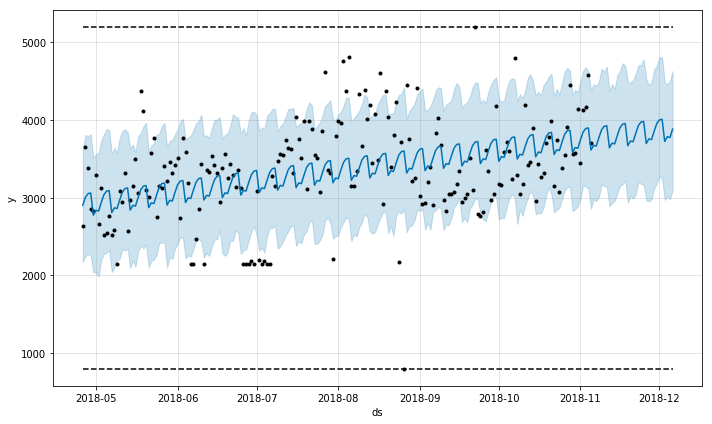

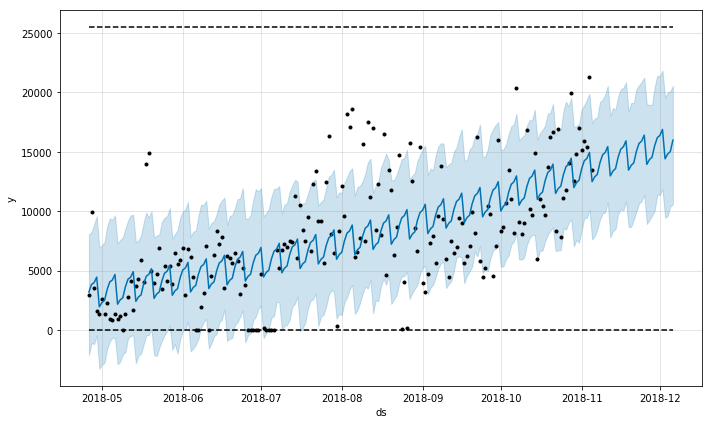

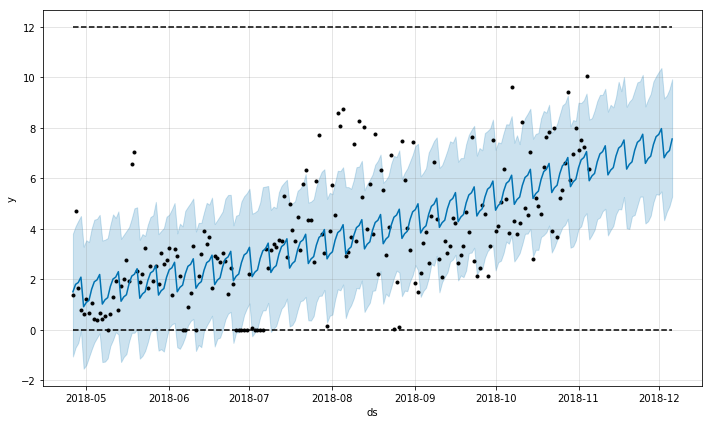

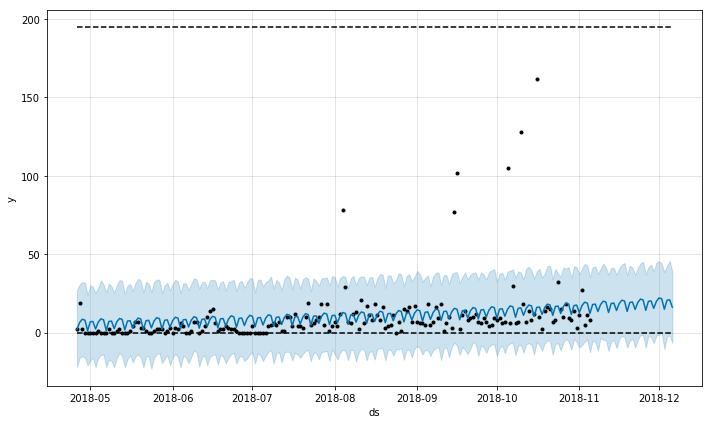

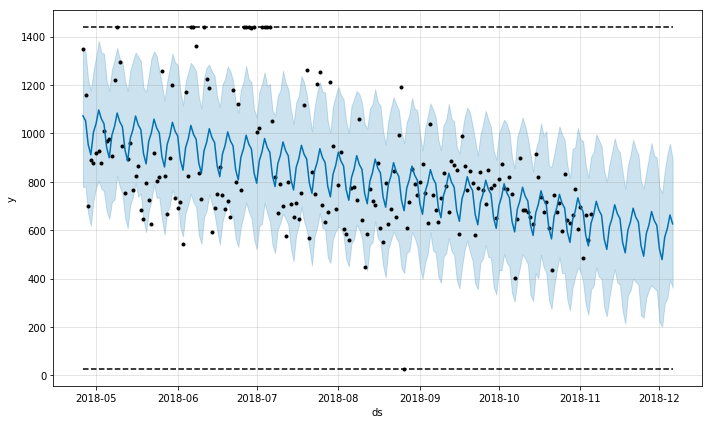

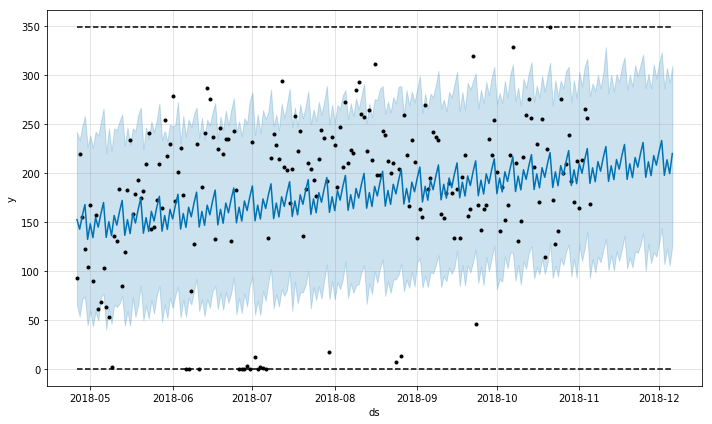

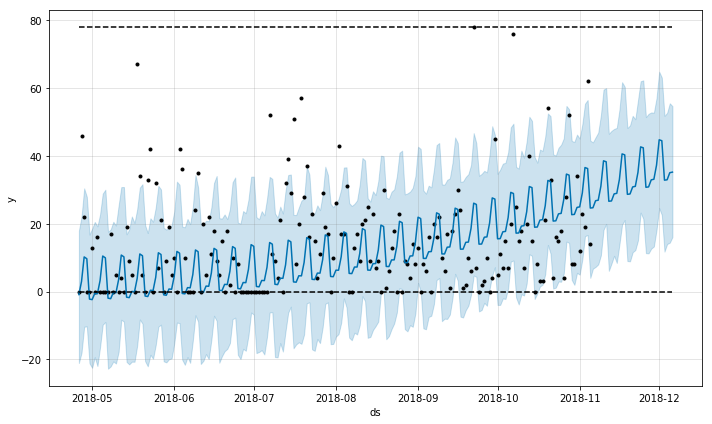

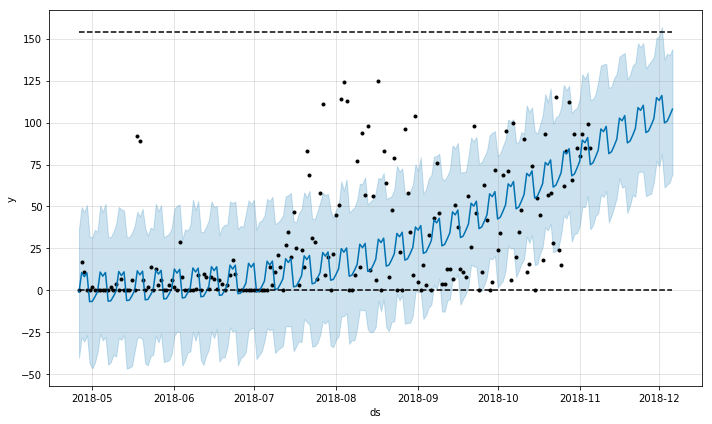

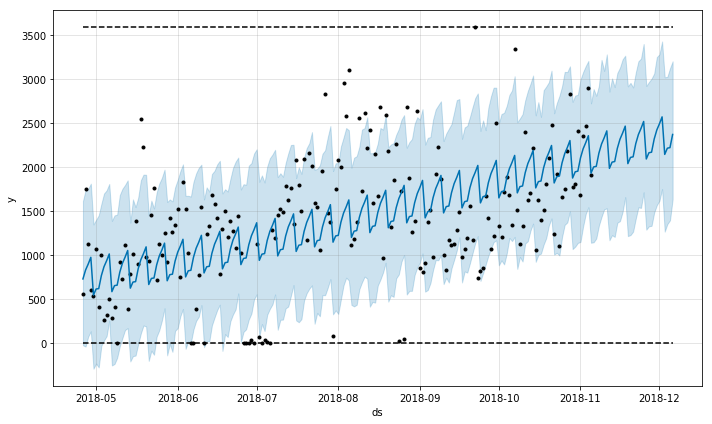

In [455]:
fb_prophet_all(fitbit, 31)

In [443]:
forecast_df

date  calories_burned_pred
225 2018-12-07           3918.376927
226 2018-12-08           4058.575666
227 2018-12-09           4506.883055
228 2018-12-10           1968.491608
229 2018-12-11           2331.298245
230 2018-12-12           2481.234619
231 2018-12-13           3381.574021
232 2018-12-14           3998.274552
233 2018-12-15           4138.378905
234 2018-12-16           4586.587679
235 2018-12-17           2048.093414
236 2018-12-18           2410.793049
237 2018-12-19           2560.618261
238 2018-12-20           3460.842366

In [445]:
fitbit.head()

calories_burned   steps  distance  floors  minutes_sedentary  \
date                                                                       
2018-04-26           2635.0  2931.0      1.38     2.0             1347.0   
2018-04-27           3649.0  9971.0      4.70    19.0             1158.0   
2018-04-28           3379.0  3521.0      1.66     2.0              702.0   
2018-04-29           2851.0  1639.0      0.77     0.0              891.0   
2018-04-30           2825.0  1323.0      0.62     0.0              880.0   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-04-26                    93.0                    0.0   
2018-04-27                   219.0                   46.0   
2018-04-28                   155.0                   22.0   
2018-04-29                   122.0                    0.0   
2018-04-30                   104.0                    0.0   

            minutes_very_active  activity_calories  calories      ...       \
date                                                              ...        
2018-04-26                  0.0              566.0       0.0      ...        
2018-04-27                 17.0             1752.0       0.0      ...        
2018-04-28                 11.0             1124.0       0.0      ...        
2018-04-29                  0.0              602.0       0.0      ...        
2018-04-30                  0.0              540.0       0.0      ...        

            fiber (g)  carbs (g)  sodium (mg)  protein (g)  water (fl oz)  \
date                                                                        
2018-04-26        0.0        0.0          0.0          0.0            0.0   
2018-04-27        0.0        0.0          0.0          0.0            0.0   
2018-04-28        0.0        0.0          0.0          0.0            0.0   
2018-04-29        0.0        0.0          0.0          0.0            0.0   
2018-04-30        0.0        0.0          0.0          0.0            0.0   

            day_of_week weekend_or_weekday total_minutes  hours_awake  \
date                                                                    
2018-04-26     Thursday            weekday        1440.0    24.000000   
2018-04-27       Friday            weekday        1440.0    24.000000   
2018-04-28     Saturday            weekend         890.0    14.833333   
2018-04-29       Sunday            weekend        1013.0    16.883333   
2018-04-30       Monday            weekday         984.0    16.400000   

            hours_asleep  
date                      
2018-04-26      0.000000  
2018-04-27      0.000000  
2018-04-28      9.166667  
2018-04-29      7.116667  
2018-04-30      7.600000  

[5 rows x 21 columns]

In [555]:
def another(df, feat, periods):
        variable = df[feat]
        train = variable[:194]
        test = variable[194:225]
        to_predict = variable[225:]
        train_df = train.to_frame()
        train_df.reset_index(inplace=True)
        train_df.rename(index=str, columns={'date':'ds'}, inplace=True)
        train_df.rename(index=str, columns={feat:'y'}, inplace=True)

        train_df['cap'] = max(df[feat])
        train_df['floor'] = min(df[feat])

        m = Prophet(growth='logistic', changepoint_range=0.9)
        m.fit(train_df)

        future = m.make_future_dataframe(periods=periods)
        future['cap'] = max(df[feat])
        future['floor'] = min(df[feat])

        forecast = m.predict(future)
        forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)

#         test_df = test.to_frame()
#         forecast_df.set_index('ds', inplace=True)
#         forecast_df = forecast_df.join(test_df)
#         forecast_df.yhat = forecast_df.yhat.astype(int)
#         forecast_df['error'] = forecast_df[feat] - forecast_df['yhat']
#         forecast_df['abs_error'] = abs(forecast_df['error'])
#         forecast_df['sqr_error'] = forecast_df['abs_error'] ** 2
#         rmse = (forecast_df.sqr_error.sum()/forecast_df.shape[0]) ** .5 
        
        forecast_df1 = forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(22)
        forecast_df1 = forecast_df1[['ds', 'yhat']]
        
        forecast_df1.rename(index=str, columns={'ds':'date'}, inplace=True)
        forecast_df1.rename(index=str, columns={'yhat': str(feat)+'_pred'}, inplace=True)
        
        
        return forecast_df1
        

In [556]:
calories = another(fitbit, 'calories_burned', 53)
calories

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


date  calories_burned_pred
225 2018-12-07           3983.859160
226 2018-12-08           4030.461224
227 2018-12-09           4037.223329
228 2018-12-10           3752.237891
229 2018-12-11           3812.997742
230 2018-12-12           3802.831293
231 2018-12-13           3911.532920
232 2018-12-14           4010.638041
233 2018-12-15           4057.193764
234 2018-12-16           4063.909415
235 2018-12-17           3778.877410
236 2018-12-18           3839.590582
237 2018-12-19           3829.377344
238 2018-12-20           3938.032073
239 2018-12-21           4037.090188
240 2018-12-22           4083.598799
241 2018-12-23           4090.267232
242 2018-12-24           3805.187904
243 2018-12-25           3865.853650
244 2018-12-26           3855.592885
245 2018-12-27           3964.199986
246 2018-12-28           4063.210374

In [557]:
dist = another(fitbit, 'distance', 53)
dist

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


date  distance_pred
225 2018-12-07       7.874745
226 2018-12-08       7.963970
227 2018-12-09       8.194519
228 2018-12-10       7.037951
229 2018-12-11       7.223378
230 2018-12-12       7.323177
231 2018-12-13       7.779967
232 2018-12-14       8.091265
233 2018-12-15       8.179823
234 2018-12-16       8.409696
235 2018-12-17       7.252441
236 2018-12-18       7.437172
237 2018-12-19       7.536264
238 2018-12-20       7.992338
239 2018-12-21       8.302911
240 2018-12-22       8.390734
241 2018-12-23       8.619862
242 2018-12-24       7.461854
243 2018-12-25       7.645822
244 2018-12-26       7.744143
245 2018-12-27       8.199438
246 2018-12-28       8.509222

In [558]:
min_sed = another(fitbit, 'minutes_sedentary', 53)
min_sed

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


date  minutes_sedentary_pred
225 2018-12-07              606.207999
226 2018-12-08              508.044440
227 2018-12-09              464.914257
228 2018-12-10              558.129118
229 2018-12-11              593.745579
230 2018-12-12              649.426646
231 2018-12-13              612.740159
232 2018-12-14              592.403318
233 2018-12-15              494.258864
234 2018-12-16              451.147987
235 2018-12-17              544.382352
236 2018-12-18              580.018516
237 2018-12-19              635.719481
238 2018-12-20              599.053089
239 2018-12-21              578.736537
240 2018-12-22              480.612564
241 2018-12-23              437.522360
242 2018-12-24              530.777589
243 2018-12-25              566.434804
244 2018-12-26              622.157010
245 2018-12-27              585.512043
246 2018-12-28              565.217103

In [553]:
def another_no_outliers(df, feat, periods):
        variable = df[feat]
        train = variable[:174]
        test = variable[144:205]
        to_predict = variable[225:]
        train_df = train.to_frame()
        train_df.reset_index(inplace=True)
        train_df.rename(index=str, columns={'date':'ds'}, inplace=True)
        train_df.rename(index=str, columns={feat:'y'}, inplace=True)

        train_df['cap'] = max(df[feat])
        train_df['floor'] = min(df[feat])

        m = Prophet(growth='logistic', changepoint_range=0.9)
        m.fit(train_df)

        future = m.make_future_dataframe(periods=periods)
        future['cap'] = max(df[feat])
        future['floor'] = min(df[feat])

        forecast = m.predict(future)
        forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)

#         test_df = test.to_frame()
#         forecast_df.set_index('ds', inplace=True)
#         forecast_df = forecast_df.join(test_df)
#         forecast_df.yhat = forecast_df.yhat.astype(int)
#         forecast_df['error'] = forecast_df[feat] - forecast_df['yhat']
#         forecast_df['abs_error'] = abs(forecast_df['error'])
#         forecast_df['sqr_error'] = forecast_df['abs_error'] ** 2
#         rmse = (forecast_df.sqr_error.sum()/forecast_df.shape[0]) ** .5 
        
        forecast_df1 = forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(22)
        forecast_df1 = forecast_df1[['ds', 'yhat']]
        
        forecast_df1.rename(index=str, columns={'ds':'date'}, inplace=True)
        forecast_df1.rename(index=str, columns={'yhat': str(feat)+'_pred'}, inplace=True)
        
        
        return forecast_df1
        

In [554]:
lightly = another_no_outliers(no_outliers, 'minutes_lightly_active', 53)
lightly

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


date  minutes_lightly_active_pred
205 2018-12-07                   237.588783
206 2018-12-08                   236.391378
207 2018-12-09                   244.111443
208 2018-12-10                   224.134770
209 2018-12-11                   231.623709
210 2018-12-12                   230.506736
211 2018-12-13                   244.866214
212 2018-12-14                   239.335549
213 2018-12-15                   238.136589
214 2018-12-16                   245.855090
215 2018-12-17                   225.876844
216 2018-12-18                   233.364203
217 2018-12-19                   232.245641
218 2018-12-20                   246.603520
219 2018-12-21                   241.071248
220 2018-12-22                   239.870673
221 2018-12-23                   247.587550
222 2018-12-24                   227.607672
223 2018-12-25                   235.093390
224 2018-12-26                   233.973179
225 2018-12-27                   248.329401
226 2018-12-28                   242.795463

calories, dist, min_sed, lightly

In [582]:
final = pd.merge(calories, dist, how='inner', on='date')
final

date  calories_burned_pred  distance_pred
0  2018-12-07           3983.859160       7.874745
1  2018-12-08           4030.461224       7.963970
2  2018-12-09           4037.223329       8.194519
3  2018-12-10           3752.237891       7.037951
4  2018-12-11           3812.997742       7.223378
5  2018-12-12           3802.831293       7.323177
6  2018-12-13           3911.532920       7.779967
7  2018-12-14           4010.638041       8.091265
8  2018-12-15           4057.193764       8.179823
9  2018-12-16           4063.909415       8.409696
10 2018-12-17           3778.877410       7.252441
11 2018-12-18           3839.590582       7.437172
12 2018-12-19           3829.377344       7.536264
13 2018-12-20           3938.032073       7.992338
14 2018-12-21           4037.090188       8.302911
15 2018-12-22           4083.598799       8.390734
16 2018-12-23           4090.267232       8.619862
17 2018-12-24           3805.187904       7.461854
18 2018-12-25           3865.853650       7.645822
19 2018-12-26           3855.592885       7.744143
20 2018-12-27           3964.199986       8.199438
21 2018-12-28           4063.210374       8.509222

In [583]:
final = pd.merge(final, min_sed, how='inner', on='date')
final = pd.merge(final, lightly, how='inner', on='date')
final

date  calories_burned_pred  distance_pred  minutes_sedentary_pred  \
0  2018-12-07           3983.859160       7.874745              606.207999   
1  2018-12-08           4030.461224       7.963970              508.044440   
2  2018-12-09           4037.223329       8.194519              464.914257   
3  2018-12-10           3752.237891       7.037951              558.129118   
4  2018-12-11           3812.997742       7.223378              593.745579   
5  2018-12-12           3802.831293       7.323177              649.426646   
6  2018-12-13           3911.532920       7.779967              612.740159   
7  2018-12-14           4010.638041       8.091265              592.403318   
8  2018-12-15           4057.193764       8.179823              494.258864   
9  2018-12-16           4063.909415       8.409696              451.147987   
10 2018-12-17           3778.877410       7.252441              544.382352   
11 2018-12-18           3839.590582       7.437172              580.018516   
12 2018-12-19           3829.377344       7.536264              635.719481   
13 2018-12-20           3938.032073       7.992338              599.053089   
14 2018-12-21           4037.090188       8.302911              578.736537   
15 2018-12-22           4083.598799       8.390734              480.612564   
16 2018-12-23           4090.267232       8.619862              437.522360   
17 2018-12-24           3805.187904       7.461854              530.777589   
18 2018-12-25           3865.853650       7.645822              566.434804   
19 2018-12-26           3855.592885       7.744143              622.157010   
20 2018-12-27           3964.199986       8.199438              585.512043   
21 2018-12-28           4063.210374       8.509222              565.217103   

    minutes_lightly_active_pred  
0                    237.588783  
1                    236.391378  
2                    244.111443  
3                    224.134770  
4                    231.623709  
5                    230.506736  
6                    244.866214  
7                    239.335549  
8                    238.136589  
9                    245.855090  
10                   225.876844  
11                   233.364203  
12                   232.245641  
13                   246.603520  
14                   241.071248  
15                   239.870673  
16                   247.587550  
17                   227.607672  
18                   235.093390  
19                   233.973179  
20                   248.329401  
21                   242.795463

In [565]:
def holt_linear(col, smoothing_level, smoothing_slope):
    print(col)
    train = fitbit[col][:194]
    test = fitbit[col][194:]

    
    yhat['avg_forecast'] = train.mean()
    yhat.head()

    def plot_data_and_predictions(predictions, label):
        plt.figure(figsize=(10, 8))

        plt.plot(train,label='Train')
        plt.plot(test, label='Test')
        plt.plot(predictions, label=label, linewidth=5)

        plt.legend(loc='best')
        plt.show()


    def evaluate(actual, predictions, output=True):
        mse = metrics.mean_squared_error(actual, predictions)
        rmse = math.sqrt(mse)

        if output:
            print('MSE:  {}'.format(mse))
            print('RMSE: {}'.format(rmse))
        else:
            return mse, rmse    

    def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
        if type(predictions) is not list:
            predictions = [predictions]

        plt.figure(figsize=(16, 8))
        plt.plot(train,label='Train')
        plt.plot(test, label='Test')

        for yhat in predictions:
#             mse, rmse = evaluate(actual, yhat, output=False)        
            label = f'{yhat.name}'
#             if len(predictions) > 1:
#                 label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
            plt.plot(yhat, label=label, linewidth=linewidth)

#         if len(predictions) == 1:
#             label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
            plt.title(label)

        plt.legend(loc='best')
        plt.show()    

    print(f'Holt Linear Trend')

    sm.tsa.seasonal_decompose(train).plot()
    result = sm.tsa.stattools.adfuller(train)
    plt.show()

    holt = Holt(train).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)

    yhat['holt_linear'] = holt.forecast(test.shape[0])

    plot_and_eval(yhat.holt_linear)
#     holt_error['holt mse'].append(mse)
#     holt_error['holt rmse'].append(rmse)
    return holt

steps
Holt Linear Trend


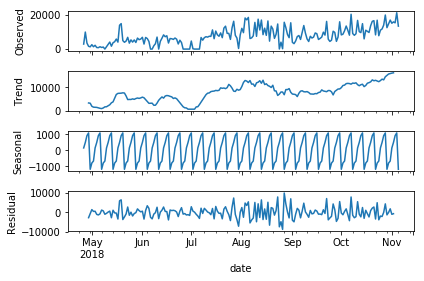

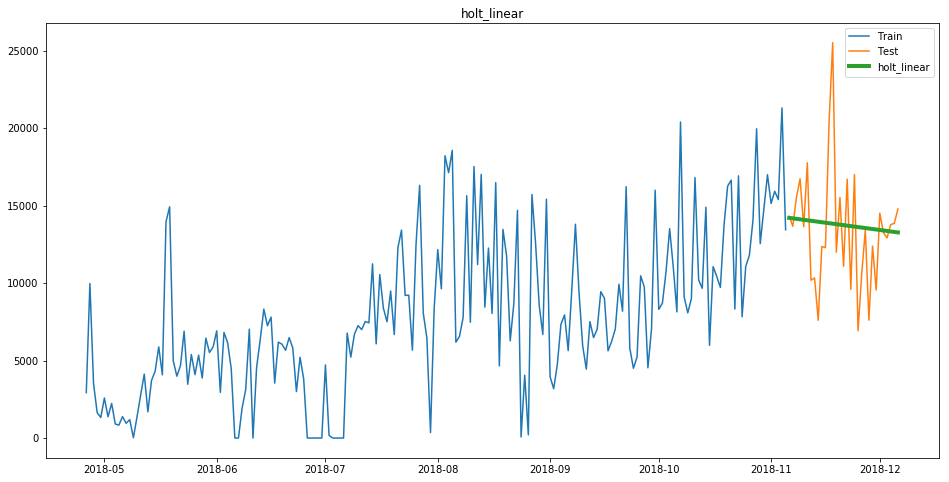

In [566]:
holt = holt_linear('steps', .9, .1)

In [584]:
matt_final = holt.forecast(fitbit.steps[194:].shape[0])[-22:]
matt_final = matt_final.to_frame()
matt_final.reset_index(inplace=True)
matt_final.rename(index=str, columns={'index':'date'}, inplace=True)
final = pd.merge(matt_final, final, how='inner', on='date')
final.rename(index=str, columns={0:'steps_pred'}, inplace=True)
final

date    steps_pred  calories_burned_pred  distance_pred  \
0  2018-12-07  13237.307165           3983.859160       7.874745   
1  2018-12-08  13205.998551           4030.461224       7.963970   
2  2018-12-09  13174.689936           4037.223329       8.194519   
3  2018-12-10  13143.381322           3752.237891       7.037951   
4  2018-12-11  13112.072707           3812.997742       7.223378   
5  2018-12-12  13080.764093           3802.831293       7.323177   
6  2018-12-13  13049.455478           3911.532920       7.779967   
7  2018-12-14  13018.146864           4010.638041       8.091265   
8  2018-12-15  12986.838249           4057.193764       8.179823   
9  2018-12-16  12955.529635           4063.909415       8.409696   
10 2018-12-17  12924.221020           3778.877410       7.252441   
11 2018-12-18  12892.912406           3839.590582       7.437172   
12 2018-12-19  12861.603791           3829.377344       7.536264   
13 2018-12-20  12830.295177           3938.032073       7.992338   
14 2018-12-21  12798.986562           4037.090188       8.302911   
15 2018-12-22  12767.677948           4083.598799       8.390734   
16 2018-12-23  12736.369333           4090.267232       8.619862   
17 2018-12-24  12705.060719           3805.187904       7.461854   
18 2018-12-25  12673.752105           3865.853650       7.645822   
19 2018-12-26  12642.443490           3855.592885       7.744143   
20 2018-12-27  12611.134876           3964.199986       8.199438   
21 2018-12-28  12579.826261           4063.210374       8.509222   

    minutes_sedentary_pred  minutes_lightly_active_pred  
0               606.207999                   237.588783  
1               508.044440                   236.391378  
2               464.914257                   244.111443  
3               558.129118                   224.134770  
4               593.745579                   231.623709  
5               649.426646                   230.506736  
6               612.740159                   244.866214  
7               592.403318                   239.335549  
8               494.258864                   238.136589  
9               451.147987                   245.855090  
10              544.382352                   225.876844  
11              580.018516                   233.364203  
12              635.719481                   232.245641  
13              599.053089                   246.603520  
14              578.736537                   241.071248  
15              480.612564                   239.870673  
16              437.522360                   247.587550  
17              530.777589                   227.607672  
18              566.434804                   235.093390  
19              622.157010                   233.973179  
20              585.512043                   248.329401  
21              565.217103                   242.795463

floors
Holt Linear Trend


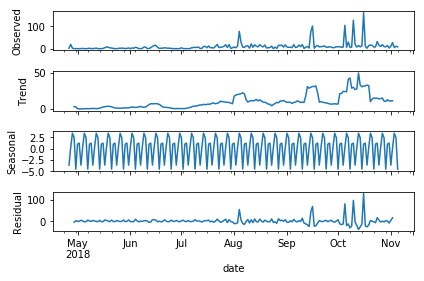

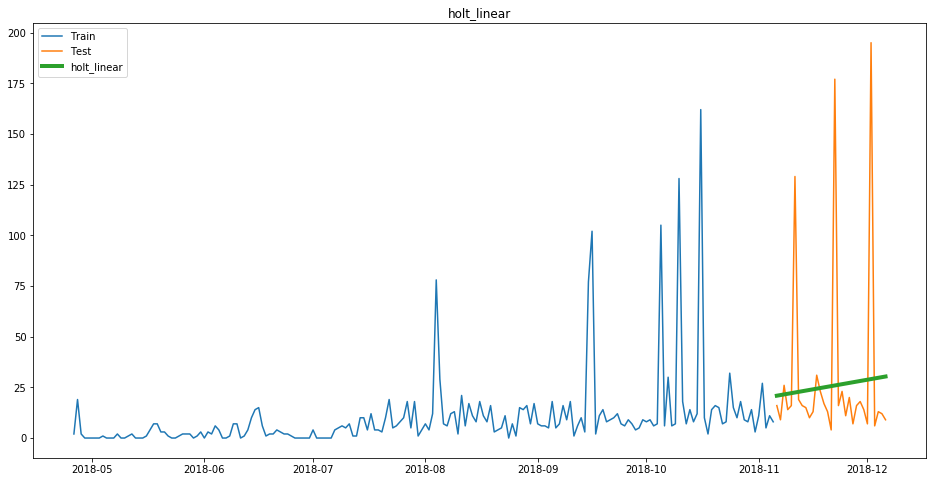

In [585]:
holt = holt_linear('floors', .095, .905)

In [586]:
floors = holt.forecast(fitbit.floors[194:].shape[0])[-22:]
floors

2018-12-07    30.662556
2018-12-08    30.978146
2018-12-09    31.293735
2018-12-10    31.609325
2018-12-11    31.924915
2018-12-12    32.240505
2018-12-13    32.556095
2018-12-14    32.871684
2018-12-15    33.187274
2018-12-16    33.502864
2018-12-17    33.818454
2018-12-18    34.134044
2018-12-19    34.449633
2018-12-20    34.765223
2018-12-21    35.080813
2018-12-22    35.396403
2018-12-23    35.711993
2018-12-24    36.027582
2018-12-25    36.343172
2018-12-26    36.658762
2018-12-27    36.974352
2018-12-28    37.289942
Freq: D, dtype: float64

In [587]:
matt_final = holt.forecast(fitbit.floors[194:].shape[0])[-22:]
matt_final = matt_final.to_frame()
matt_final.reset_index(inplace=True)
matt_final.rename(index=str, columns={'index':'date'}, inplace=True)
final = pd.merge(matt_final, final, how='inner', on='date')
final.rename(index=str, columns={0:'floors_pred'}, inplace=True)
final

date  floors_pred    steps_pred  calories_burned_pred  distance_pred  \
0  2018-12-07    30.662556  13237.307165           3983.859160       7.874745   
1  2018-12-08    30.978146  13205.998551           4030.461224       7.963970   
2  2018-12-09    31.293735  13174.689936           4037.223329       8.194519   
3  2018-12-10    31.609325  13143.381322           3752.237891       7.037951   
4  2018-12-11    31.924915  13112.072707           3812.997742       7.223378   
5  2018-12-12    32.240505  13080.764093           3802.831293       7.323177   
6  2018-12-13    32.556095  13049.455478           3911.532920       7.779967   
7  2018-12-14    32.871684  13018.146864           4010.638041       8.091265   
8  2018-12-15    33.187274  12986.838249           4057.193764       8.179823   
9  2018-12-16    33.502864  12955.529635           4063.909415       8.409696   
10 2018-12-17    33.818454  12924.221020           3778.877410       7.252441   
11 2018-12-18    34.134044  12892.912406           3839.590582       7.437172   
12 2018-12-19    34.449633  12861.603791           3829.377344       7.536264   
13 2018-12-20    34.765223  12830.295177           3938.032073       7.992338   
14 2018-12-21    35.080813  12798.986562           4037.090188       8.302911   
15 2018-12-22    35.396403  12767.677948           4083.598799       8.390734   
16 2018-12-23    35.711993  12736.369333           4090.267232       8.619862   
17 2018-12-24    36.027582  12705.060719           3805.187904       7.461854   
18 2018-12-25    36.343172  12673.752105           3865.853650       7.645822   
19 2018-12-26    36.658762  12642.443490           3855.592885       7.744143   
20 2018-12-27    36.974352  12611.134876           3964.199986       8.199438   
21 2018-12-28    37.289942  12579.826261           4063.210374       8.509222   

    minutes_sedentary_pred  minutes_lightly_active_pred  
0               606.207999                   237.588783  
1               508.044440                   236.391378  
2               464.914257                   244.111443  
3               558.129118                   224.134770  
4               593.745579                   231.623709  
5               649.426646                   230.506736  
6               612.740159                   244.866214  
7               592.403318                   239.335549  
8               494.258864                   238.136589  
9               451.147987                   245.855090  
10              544.382352                   225.876844  
11              580.018516                   233.364203  
12              635.719481                   232.245641  
13              599.053089                   246.603520  
14              578.736537                   241.071248  
15              480.612564                   239.870673  
16              437.522360                   247.587550  
17              530.777589                   227.607672  
18              566.434804                   235.093390  
19              622.157010                   233.973179  
20              585.512043                   248.329401  
21              565.217103                   242.795463

In [588]:
col = 'minutes_fairly_active'
train = fitbit[col][:225]

train.rolling(60).mean().iloc[-1]

18.75

In [589]:
final['minutes_fairly_active_pred'] = 18.75
final.head()

date  floors_pred    steps_pred  calories_burned_pred  distance_pred  \
0 2018-12-07    30.662556  13237.307165           3983.859160       7.874745   
1 2018-12-08    30.978146  13205.998551           4030.461224       7.963970   
2 2018-12-09    31.293735  13174.689936           4037.223329       8.194519   
3 2018-12-10    31.609325  13143.381322           3752.237891       7.037951   
4 2018-12-11    31.924915  13112.072707           3812.997742       7.223378   

   minutes_sedentary_pred  minutes_lightly_active_pred  \
0              606.207999                   237.588783   
1              508.044440                   236.391378   
2              464.914257                   244.111443   
3              558.129118                   224.134770   
4              593.745579                   231.623709   

   minutes_fairly_active_pred  
0                       18.75  
1                       18.75  
2                       18.75  
3                       18.75  
4                       18.75

In [591]:
final['dist_pred_reg'] = final['steps_pred'] * 0.00047288 + -.0051139
final.head()

date  floors_pred    steps_pred  calories_burned_pred  distance_pred  \
0 2018-12-07    30.662556  13237.307165           3983.859160       7.874745   
1 2018-12-08    30.978146  13205.998551           4030.461224       7.963970   
2 2018-12-09    31.293735  13174.689936           4037.223329       8.194519   
3 2018-12-10    31.609325  13143.381322           3752.237891       7.037951   
4 2018-12-11    31.924915  13112.072707           3812.997742       7.223378   

   minutes_sedentary_pred  minutes_lightly_active_pred  \
0              606.207999                   237.588783   
1              508.044440                   236.391378   
2              464.914257                   244.111443   
3              558.129118                   224.134770   
4              593.745579                   231.623709   

   minutes_fairly_active_pred  steps_pred_reg  dist_pred_reg  
0                       18.75        6.254544       6.254544  
1                       18.75        6.239739       6.239739  
2                       18.75        6.224933       6.224933  
3                       18.75        6.210128       6.210128  
4                       18.75        6.195323       6.195323

In [592]:
col = 'minutes_very_active'
train = fitbit[col][:225]

train.rolling(30).mean().iloc[-1]

62.36666666666667

In [593]:
final['minutes_very_active_pred'] = 62.37
final.head()

date  floors_pred    steps_pred  calories_burned_pred  distance_pred  \
0 2018-12-07    30.662556  13237.307165           3983.859160       7.874745   
1 2018-12-08    30.978146  13205.998551           4030.461224       7.963970   
2 2018-12-09    31.293735  13174.689936           4037.223329       8.194519   
3 2018-12-10    31.609325  13143.381322           3752.237891       7.037951   
4 2018-12-11    31.924915  13112.072707           3812.997742       7.223378   

   minutes_sedentary_pred  minutes_lightly_active_pred  \
0              606.207999                   237.588783   
1              508.044440                   236.391378   
2              464.914257                   244.111443   
3              558.129118                   224.134770   
4              593.745579                   231.623709   

   minutes_fairly_active_pred  steps_pred_reg  dist_pred_reg  \
0                       18.75        6.254544       6.254544   
1                       18.75        6.239739       6.239739   
2                       18.75        6.224933       6.224933   
3                       18.75        6.210128       6.210128   
4                       18.75        6.195323       6.195323   

   minutes_very_active_pred  
0                     62.37  
1                     62.37  
2                     62.37  
3                     62.37  
4                     62.37

In [594]:
final.isnull().sum()

date                           0
floors_pred                    0
steps_pred                     0
calories_burned_pred           0
distance_pred                  0
minutes_sedentary_pred         0
minutes_lightly_active_pred    0
minutes_fairly_active_pred     0
steps_pred_reg                 0
dist_pred_reg                  0
minutes_very_active_pred       0
dtype: int64

In [595]:
final.tail()

date  floors_pred    steps_pred  calories_burned_pred  distance_pred  \
17 2018-12-24    36.027582  12705.060719           3805.187904       7.461854   
18 2018-12-25    36.343172  12673.752105           3865.853650       7.645822   
19 2018-12-26    36.658762  12642.443490           3855.592885       7.744143   
20 2018-12-27    36.974352  12611.134876           3964.199986       8.199438   
21 2018-12-28    37.289942  12579.826261           4063.210374       8.509222   

    minutes_sedentary_pred  minutes_lightly_active_pred  \
17              530.777589                   227.607672   
18              566.434804                   235.093390   
19              622.157010                   233.973179   
20              585.512043                   248.329401   
21              565.217103                   242.795463   

    minutes_fairly_active_pred  steps_pred_reg  dist_pred_reg  \
17                       18.75        6.002855       6.002855   
18                       18.75        5.988050       5.988050   
19                       18.75        5.973245       5.973245   
20                       18.75        5.958440       5.958440   
21                       18.75        5.943634       5.943634   

    minutes_very_active_pred  
17                     62.37  
18                     62.37  
19                     62.37  
20                     62.37  
21                     62.37

In [597]:
final.drop(columns='steps_pred_reg', inplace=True)
final.head()

date  floors_pred    steps_pred  calories_burned_pred  distance_pred  \
0 2018-12-07    30.662556  13237.307165           3983.859160       7.874745   
1 2018-12-08    30.978146  13205.998551           4030.461224       7.963970   
2 2018-12-09    31.293735  13174.689936           4037.223329       8.194519   
3 2018-12-10    31.609325  13143.381322           3752.237891       7.037951   
4 2018-12-11    31.924915  13112.072707           3812.997742       7.223378   

   minutes_sedentary_pred  minutes_lightly_active_pred  \
0              606.207999                   237.588783   
1              508.044440                   236.391378   
2              464.914257                   244.111443   
3              558.129118                   224.134770   
4              593.745579                   231.623709   

   minutes_fairly_active_pred  dist_pred_reg  minutes_very_active_pred  
0                       18.75       6.254544                     62.37  
1                       18.75       6.239739                     62.37  
2                       18.75       6.224933                     62.37  
3                       18.75       6.210128                     62.37  
4                       18.75       6.195323                     62.37

In [598]:
act_cal = another_no_outliers(no_outliers, 'activity_calories', 53)
act_cal

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


date  activity_calories_pred
205 2018-12-07             2359.482756
206 2018-12-08             2308.240308
207 2018-12-09             2366.143009
208 2018-12-10             2018.647536
209 2018-12-11             2022.787120
210 2018-12-12             2113.939215
211 2018-12-13             2228.676053
212 2018-12-14             2397.562781
213 2018-12-15             2346.285005
214 2018-12-16             2404.151519
215 2018-12-17             2056.619007
216 2018-12-18             2060.720702
217 2018-12-19             2151.834060
218 2018-12-20             2266.531320
219 2018-12-21             2435.377629
220 2018-12-22             2384.058598
221 2018-12-23             2441.883026
222 2018-12-24             2094.307600
223 2018-12-25             2098.365556
224 2018-12-26             2189.434355
225 2018-12-27             2304.086239
226 2018-12-28             2472.886361

In [599]:
final = pd.merge(final, act_cal, how='inner', on='date')
final

date  floors_pred    steps_pred  calories_burned_pred  distance_pred  \
0  2018-12-07    30.662556  13237.307165           3983.859160       7.874745   
1  2018-12-08    30.978146  13205.998551           4030.461224       7.963970   
2  2018-12-09    31.293735  13174.689936           4037.223329       8.194519   
3  2018-12-10    31.609325  13143.381322           3752.237891       7.037951   
4  2018-12-11    31.924915  13112.072707           3812.997742       7.223378   
5  2018-12-12    32.240505  13080.764093           3802.831293       7.323177   
6  2018-12-13    32.556095  13049.455478           3911.532920       7.779967   
7  2018-12-14    32.871684  13018.146864           4010.638041       8.091265   
8  2018-12-15    33.187274  12986.838249           4057.193764       8.179823   
9  2018-12-16    33.502864  12955.529635           4063.909415       8.409696   
10 2018-12-17    33.818454  12924.221020           3778.877410       7.252441   
11 2018-12-18    34.134044  12892.912406           3839.590582       7.437172   
12 2018-12-19    34.449633  12861.603791           3829.377344       7.536264   
13 2018-12-20    34.765223  12830.295177           3938.032073       7.992338   
14 2018-12-21    35.080813  12798.986562           4037.090188       8.302911   
15 2018-12-22    35.396403  12767.677948           4083.598799       8.390734   
16 2018-12-23    35.711993  12736.369333           4090.267232       8.619862   
17 2018-12-24    36.027582  12705.060719           3805.187904       7.461854   
18 2018-12-25    36.343172  12673.752105           3865.853650       7.645822   
19 2018-12-26    36.658762  12642.443490           3855.592885       7.744143   
20 2018-12-27    36.974352  12611.134876           3964.199986       8.199438   
21 2018-12-28    37.289942  12579.826261           4063.210374       8.509222   

    minutes_sedentary_pred  minutes_lightly_active_pred  \
0               606.207999                   237.588783   
1               508.044440                   236.391378   
2               464.914257                   244.111443   
3               558.129118                   224.134770   
4               593.745579                   231.623709   
5               649.426646                   230.506736   
6               612.740159                   244.866214   
7               592.403318                   239.335549   
8               494.258864                   238.136589   
9               451.147987                   245.855090   
10              544.382352                   225.876844   
11              580.018516                   233.364203   
12              635.719481                   232.245641   
13              599.053089                   246.603520   
14              578.736537                   241.071248   
15              480.612564                   239.870673   
16              437.522360                   247.587550   
17              530.777589                   227.607672   
18              566.434804                   235.093390   
19              622.157010                   233.973179   
20              585.512043                   248.329401   
21              565.217103                   242.795463   

    minutes_fairly_active_pred  dist_pred_reg  minutes_very_active_pred  \
0                        18.75       6.254544                     62.37   
1                        18.75       6.239739                     62.37   
2                        18.75       6.224933                     62.37   
3                        18.75       6.210128                     62.37   
4                        18.75       6.195323                     62.37   
5                        18.75       6.180518                     62.37   
6                        18.75       6.165713                     62.37   
7                        18.75       6.150907                     62.37   
8                        18.75       6.136102                     62.37   
9                        18.75       

In [600]:
list(final)

['date',
 'floors_pred',
 'steps_pred',
 'calories_burned_pred',
 'distance_pred',
 'minutes_sedentary_pred',
 'minutes_lightly_active_pred',
 'minutes_fairly_active_pred',
 'dist_pred_reg',
 'minutes_very_active_pred',
 'activity_calories_pred']

In [601]:
final = final[['date',
 'floors_pred',
 'steps_pred',
 'calories_burned_pred',
 'distance_pred',
 'dist_pred_reg',
 'minutes_sedentary_pred',
 'minutes_lightly_active_pred',
 'minutes_fairly_active_pred',
 'minutes_very_active_pred',
 'activity_calories_pred']]
final

date  floors_pred    steps_pred  calories_burned_pred  distance_pred  \
0  2018-12-07    30.662556  13237.307165           3983.859160       7.874745   
1  2018-12-08    30.978146  13205.998551           4030.461224       7.963970   
2  2018-12-09    31.293735  13174.689936           4037.223329       8.194519   
3  2018-12-10    31.609325  13143.381322           3752.237891       7.037951   
4  2018-12-11    31.924915  13112.072707           3812.997742       7.223378   
5  2018-12-12    32.240505  13080.764093           3802.831293       7.323177   
6  2018-12-13    32.556095  13049.455478           3911.532920       7.779967   
7  2018-12-14    32.871684  13018.146864           4010.638041       8.091265   
8  2018-12-15    33.187274  12986.838249           4057.193764       8.179823   
9  2018-12-16    33.502864  12955.529635           4063.909415       8.409696   
10 2018-12-17    33.818454  12924.221020           3778.877410       7.252441   
11 2018-12-18    34.134044  12892.912406           3839.590582       7.437172   
12 2018-12-19    34.449633  12861.603791           3829.377344       7.536264   
13 2018-12-20    34.765223  12830.295177           3938.032073       7.992338   
14 2018-12-21    35.080813  12798.986562           4037.090188       8.302911   
15 2018-12-22    35.396403  12767.677948           4083.598799       8.390734   
16 2018-12-23    35.711993  12736.369333           4090.267232       8.619862   
17 2018-12-24    36.027582  12705.060719           3805.187904       7.461854   
18 2018-12-25    36.343172  12673.752105           3865.853650       7.645822   
19 2018-12-26    36.658762  12642.443490           3855.592885       7.744143   
20 2018-12-27    36.974352  12611.134876           3964.199986       8.199438   
21 2018-12-28    37.289942  12579.826261           4063.210374       8.509222   

    dist_pred_reg  minutes_sedentary_pred  minutes_lightly_active_pred  \
0        6.254544              606.207999                   237.588783   
1        6.239739              508.044440                   236.391378   
2        6.224933              464.914257                   244.111443   
3        6.210128              558.129118                   224.134770   
4        6.195323              593.745579                   231.623709   
5        6.180518              649.426646                   230.506736   
6        6.165713              612.740159                   244.866214   
7        6.150907              592.403318                   239.335549   
8        6.136102              494.258864                   238.136589   
9        6.121297              451.147987                   245.855090   
10       6.106492              544.382352                   225.876844   
11       6.091687              580.018516                   233.364203   
12       6.076881              635.719481                   232.245641   
13       6.062076              599.053089                   246.603520   
14       6.047271              578.736537                   241.071248   
15       6.032466              480.612564                   239.870673   
16       6.017660              437.522360                   247.587550   
17       6.002855              530.777589                   227.607672   
18       5.988050              566.434804                   235.093390   
19       5.973245              622.157010                   233.973179   
20       5.958440              585.512043                   248.329401   
21       5.943634              565.217103                   242.795463   

    minutes_fairly_active_pred  minutes_very_active_pred  \
0                        18.75                     62.37   
1                        18.75                     62.37   
2                        18.75                     62.37   
3                        18.75                     62.37   
4                        18.75                     62.37   
5                        18.75                     62.37   
6                     

In [602]:
final['activity_calories_pred_reg'] = final['steps_pred'] * 0.1375875 + 324.485
final.head()

date  floors_pred    steps_pred  calories_burned_pred  distance_pred  \
0 2018-12-07    30.662556  13237.307165           3983.859160       7.874745   
1 2018-12-08    30.978146  13205.998551           4030.461224       7.963970   
2 2018-12-09    31.293735  13174.689936           4037.223329       8.194519   
3 2018-12-10    31.609325  13143.381322           3752.237891       7.037951   
4 2018-12-11    31.924915  13112.072707           3812.997742       7.223378   

   dist_pred_reg  minutes_sedentary_pred  minutes_lightly_active_pred  \
0       6.254544              606.207999                   237.588783   
1       6.239739              508.044440                   236.391378   
2       6.224933              464.914257                   244.111443   
3       6.210128              558.129118                   224.134770   
4       6.195323              593.745579                   231.623709   

   minutes_fairly_active_pred  minutes_very_active_pred  \
0                       18.75                     62.37   
1                       18.75                     62.37   
2                       18.75                     62.37   
3                       18.75                     62.37   
4                       18.75                     62.37   

   activity_calories_pred  activity_calories_pred_reg  
0             2359.482756                 2145.773000  
1             2308.240308                 2141.465326  
2             2366.143009                 2137.157652  
3             2018.647536                 2132.849978  
4             2022.787120                 2128.542304

In [603]:
final.to_csv('final.csv', index=False)

In [606]:
preds = pd.read_csv(r'final.csv', index_col='date')
preds

floors_pred    steps_pred  calories_burned_pred  distance_pred  \
date                                                                         
2018-12-07    30.662556  13237.307165           3983.859160       7.874745   
2018-12-08    30.978146  13205.998551           4030.461224       7.963970   
2018-12-09    31.293735  13174.689936           4037.223329       8.194519   
2018-12-10    31.609325  13143.381322           3752.237891       7.037951   
2018-12-11    31.924915  13112.072707           3812.997742       7.223378   
2018-12-12    32.240505  13080.764093           3802.831293       7.323177   
2018-12-13    32.556095  13049.455478           3911.532920       7.779967   
2018-12-14    32.871684  13018.146864           4010.638041       8.091265   
2018-12-15    33.187274  12986.838249           4057.193764       8.179823   
2018-12-16    33.502864  12955.529635           4063.909415       8.409696   
2018-12-17    33.818454  12924.221020           3778.877410       7.252441   
2018-12-18    34.134044  12892.912406           3839.590582       7.437172   
2018-12-19    34.449633  12861.603791           3829.377344       7.536264   
2018-12-20    34.765223  12830.295177           3938.032073       7.992338   
2018-12-21    35.080813  12798.986562           4037.090188       8.302911   
2018-12-22    35.396403  12767.677948           4083.598799       8.390734   
2018-12-23    35.711993  12736.369333           4090.267232       8.619862   
2018-12-24    36.027582  12705.060719           3805.187904       7.461854   
2018-12-25    36.343172  12673.752105           3865.853650       7.645822   
2018-12-26    36.658762  12642.443490           3855.592885       7.744143   
2018-12-27    36.974352  12611.134876           3964.199986       8.199438   
2018-12-28    37.289942  12579.826261           4063.210374       8.509222   

            dist_pred_reg  minutes_sedentary_pred  \
date                                                
2018-12-07       6.254544              606.207999   
2018-12-08       6.239739              508.044440   
2018-12-09       6.224933              464.914257   
2018-12-10       6.210128              558.129118   
2018-12-11       6.195323              593.745579   
2018-12-12       6.180518              649.426646   
2018-12-13       6.165713              612.740159   
2018-12-14       6.150907              592.403318   
2018-12-15       6.136102              494.258864   
2018-12-16       6.121297              451.147987   
2018-12-17       6.106492              544.382352   
2018-12-18       6.091687              580.018516   
2018-12-19       6.076881              635.719481   
2018-12-20       6.062076              599.053089   
2018-12-21       6.047271              578.736537   
2018-12-22       6.032466              480.612564   
2018-12-23       6.017660              437.522360   
2018-12-24       6.002855              530.777589   
2018-12-25       5.988050              566.434804   
2018-12-26       5.973245              622.157010   
2018-12-27       5.958440              585.512043   
2018-12-28       5.943634              565.217103   

            minutes_lightly_active_pred  minutes_fairly_active_pred  \
date                                                                  
2018-12-07                   237.588783                       18.75   
2018-12-08                   236.391378                       18.75   
2018-12-09                   244.111443                       18.75   
2018-12-10                   224.134770                       18.75   
2018-12-11                   231.623709                       18.75   
2018-12-12                   230.506736                       18.75   
2018-12-13                   244.866214                       18.75   
2018-12-14                   239.335549                       18.75   
2018-12-15                   238.136589                       18.75   
2018-12-16                   245.855090                       18.75   
2018-12-17    

In [607]:
fitbit.head()

calories_burned   steps  distance  floors  minutes_sedentary  \
date                                                                       
2018-04-26           2635.0  2931.0      1.38     2.0             1347.0   
2018-04-27           3649.0  9971.0      4.70    19.0             1158.0   
2018-04-28           3379.0  3521.0      1.66     2.0              702.0   
2018-04-29           2851.0  1639.0      0.77     0.0              891.0   
2018-04-30           2825.0  1323.0      0.62     0.0              880.0   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-04-26                    93.0                    0.0   
2018-04-27                   219.0                   46.0   
2018-04-28                   155.0                   22.0   
2018-04-29                   122.0                    0.0   
2018-04-30                   104.0                    0.0   

            minutes_very_active  activity_calories  calories      ...       \
date                                                              ...        
2018-04-26                  0.0              566.0       0.0      ...        
2018-04-27                 17.0             1752.0       0.0      ...        
2018-04-28                 11.0             1124.0       0.0      ...        
2018-04-29                  0.0              602.0       0.0      ...        
2018-04-30                  0.0              540.0       0.0      ...        

            fiber (g)  carbs (g)  sodium (mg)  protein (g)  water (fl oz)  \
date                                                                        
2018-04-26        0.0        0.0          0.0          0.0            0.0   
2018-04-27        0.0        0.0          0.0          0.0            0.0   
2018-04-28        0.0        0.0          0.0          0.0            0.0   
2018-04-29        0.0        0.0          0.0          0.0            0.0   
2018-04-30        0.0        0.0          0.0          0.0            0.0   

            day_of_week weekend_or_weekday total_minutes  hours_awake  \
date                                                                    
2018-04-26     Thursday            weekday        1440.0    24.000000   
2018-04-27       Friday            weekday        1440.0    24.000000   
2018-04-28     Saturday            weekend         890.0    14.833333   
2018-04-29       Sunday            weekend        1013.0    16.883333   
2018-04-30       Monday            weekday         984.0    16.400000   

            hours_asleep  
date                      
2018-04-26      0.000000  
2018-04-27      0.000000  
2018-04-28      9.166667  
2018-04-29      7.116667  
2018-04-30      7.600000  

[5 rows x 21 columns]

In [608]:
list(fitbit)

['calories_burned',
 'steps',
 'distance',
 'floors',
 'minutes_sedentary',
 'minutes_lightly_active',
 'minutes_fairly_active',
 'minutes_very_active',
 'activity_calories',
 'calories',
 'fat (g)',
 'fiber (g)',
 'carbs (g)',
 'sodium (mg)',
 'protein (g)',
 'water (fl oz)',
 'day_of_week',
 'weekend_or_weekday',
 'total_minutes',
 'hours_awake',
 'hours_asleep']

In [612]:
tuesdays = fitbit[fitbit.day_of_week == 'Tuesday']
tuesdays

calories_burned    steps  distance  floors  minutes_sedentary  \
date                                                                        
2018-05-01           3292.0   2581.0      1.22     0.0              919.0   
2018-05-08           2591.0   1187.0      0.56     2.0             1221.0   
2018-05-15           3152.0   4313.0      2.03     0.0              767.0   
2018-05-22           3581.0   4680.0      2.21     1.0              625.0   
2018-05-29           3466.0   6448.0      3.04     0.0              899.0   
2018-06-05           3189.0   4486.0      2.12     4.0              823.0   
2018-06-12           3352.0   4535.0      2.14     1.0             1224.0   
2018-06-19           3560.0   6055.0      2.86     2.0              686.0   
2018-06-26           2144.0      0.0      0.00     0.0             1440.0   
2018-07-03           2144.0      0.0      0.00     0.0             1440.0   
2018-07-10           3562.0   7253.0      3.42     5.0              790.0   
2018-07-17           3760.0   8377.0      3.95    12.0              646.0   
2018-07-24           3510.0   9215.0      4.35     6.0             1203.0   
2018-07-31           3800.0   8295.0      3.91     4.0              688.0   
2018-08-07           3152.0   6558.0      3.09     6.0              777.0   
2018-08-14           3454.0   8448.0      3.98    11.0              719.0   
2018-08-21           3393.0   6274.0      2.96     4.0              689.0   
2018-08-28           3757.0  12569.0      5.93    14.0              717.0   
2018-09-04           3201.0   7343.0      3.46     5.0              631.0   
2018-09-11           2824.0   4446.0      2.10     1.0              781.0   
2018-09-18           2997.0   6247.0      2.95    11.0              866.0   
2018-09-25           2820.0   5219.0      2.46     6.0              767.0   
2018-10-02           3162.0   8702.0      4.10     9.0              872.0   
2018-10-09           3046.0   8076.0      3.81     7.0              900.0   
2018-10-16           3432.0  11061.0      5.22   162.0              819.0   
2018-10-23           3739.0  16918.0      7.98     8.0              674.0   
2018-10-30           3572.0  14794.0      6.98    14.0              771.0   
2018-11-06           3801.0  14300.0      6.74    16.0              659.0   
2018-11-13           3202.0  10330.0      4.87    16.0              615.0   
2018-11-20           3966.0  15527.0      7.27    13.0              810.0   
2018-11-27           3726.0  13420.0      6.29     7.0              650.0   
2018-12-04           3384.0  13763.0      6.49    13.0              608.0   
2018-12-11              NaN      NaN       NaN     NaN                NaN   
2018-12-18              NaN      NaN       NaN     NaN                NaN   
2018-12-25              NaN      NaN       NaN     NaN                NaN   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-05-01                   167.0                   13.0   
2018-05-08                    53.0                   17.0   
2018-05-15                   183.0                    9.0   
2018-05-22                   209.0                   33.0   
2018-05-29                   254.0                    9.0   
2018-06-05                   177.0                   10.0   
2018-06-12                   186.0                   20.0   
2018-06-19                   246.0                   15.0   
2018-06-26                     0.0                    0.0   
2018-07-03                     0.0                    0.0   
2018-07-10                   228.0                    4.0   
2018-07-17                   258.0                    8.0   
2018-07-24                   193.0                   15.0   
2018-07-31                   237.0                   10.0   
2018-08-07                   223.0                    0.0   
2018-08-14                   264.0                    9.0   
2018-08-21                   212.0                    6.0   
201

In [614]:
tuesdays = tuesdays[tuesdays.steps >= 0]
tuesdays

calories_burned    steps  distance  floors  minutes_sedentary  \
date                                                                        
2018-05-01           3292.0   2581.0      1.22     0.0              919.0   
2018-05-08           2591.0   1187.0      0.56     2.0             1221.0   
2018-05-15           3152.0   4313.0      2.03     0.0              767.0   
2018-05-22           3581.0   4680.0      2.21     1.0              625.0   
2018-05-29           3466.0   6448.0      3.04     0.0              899.0   
2018-06-05           3189.0   4486.0      2.12     4.0              823.0   
2018-06-12           3352.0   4535.0      2.14     1.0             1224.0   
2018-06-19           3560.0   6055.0      2.86     2.0              686.0   
2018-06-26           2144.0      0.0      0.00     0.0             1440.0   
2018-07-03           2144.0      0.0      0.00     0.0             1440.0   
2018-07-10           3562.0   7253.0      3.42     5.0              790.0   
2018-07-17           3760.0   8377.0      3.95    12.0              646.0   
2018-07-24           3510.0   9215.0      4.35     6.0             1203.0   
2018-07-31           3800.0   8295.0      3.91     4.0              688.0   
2018-08-07           3152.0   6558.0      3.09     6.0              777.0   
2018-08-14           3454.0   8448.0      3.98    11.0              719.0   
2018-08-21           3393.0   6274.0      2.96     4.0              689.0   
2018-08-28           3757.0  12569.0      5.93    14.0              717.0   
2018-09-04           3201.0   7343.0      3.46     5.0              631.0   
2018-09-11           2824.0   4446.0      2.10     1.0              781.0   
2018-09-18           2997.0   6247.0      2.95    11.0              866.0   
2018-09-25           2820.0   5219.0      2.46     6.0              767.0   
2018-10-02           3162.0   8702.0      4.10     9.0              872.0   
2018-10-09           3046.0   8076.0      3.81     7.0              900.0   
2018-10-16           3432.0  11061.0      5.22   162.0              819.0   
2018-10-23           3739.0  16918.0      7.98     8.0              674.0   
2018-10-30           3572.0  14794.0      6.98    14.0              771.0   
2018-11-06           3801.0  14300.0      6.74    16.0              659.0   
2018-11-13           3202.0  10330.0      4.87    16.0              615.0   
2018-11-20           3966.0  15527.0      7.27    13.0              810.0   
2018-11-27           3726.0  13420.0      6.29     7.0              650.0   
2018-12-04           3384.0  13763.0      6.49    13.0              608.0   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-05-01                   167.0                   13.0   
2018-05-08                    53.0                   17.0   
2018-05-15                   183.0                    9.0   
2018-05-22                   209.0                   33.0   
2018-05-29                   254.0                    9.0   
2018-06-05                   177.0                   10.0   
2018-06-12                   186.0                   20.0   
2018-06-19                   246.0                   15.0   
2018-06-26                     0.0                    0.0   
2018-07-03                     0.0                    0.0   
2018-07-10                   228.0                    4.0   
2018-07-17                   258.0                    8.0   
2018-07-24                   193.0                   15.0   
2018-07-31                   237.0                   10.0   
2018-08-07                   223.0                    0.0   
2018-08-14                   264.0                    9.0   
2018-08-21                   212.0                    6.0   
2018-08-28                   218.0                    8.0   
2018-09-04                   269.0                    6.0   
2018-09-11                   154.0                    6.0   
2018-09-18                   196.0                 

In [617]:
scaler = MinMaxScaler()
scaler.fit(tuesdays[['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories']])
tuesdays[['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories']] = scaler.transform(tuesdays[['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories']])
tuesdays.head()

calories_burned     steps  distance    floors  minutes_sedentary  \
date                                                                           
2018-05-01         0.630077  0.152559  0.152882  0.000000           0.373798   
2018-05-08         0.245335  0.070162  0.070175  0.012346           0.736779   
2018-05-15         0.553238  0.254936  0.254386  0.000000           0.191106   
2018-05-22         0.788694  0.276628  0.276942  0.006173           0.020433   
2018-05-29         0.725576  0.381133  0.380952  0.000000           0.349760   

            minutes_lightly_active  minutes_fairly_active  \
date                                                        
2018-05-01                0.620818               0.393939   
2018-05-08                0.197026               0.515152   
2018-05-15                0.680297               0.272727   
2018-05-22                0.776952               1.000000   
2018-05-29                0.944238               0.272727   

            minutes_very_active  activity_calories  calories      ...       \
date                                                              ...        
2018-05-01             0.017391           0.472566       0.0      ...        
2018-05-08             0.017391           0.181416       0.0      ...        
2018-05-15             0.000000           0.447345       0.0      ...        
2018-05-22             0.017391           0.646018       0.0      ...        
2018-05-29             0.000000           0.631416       0.0      ...        

            fiber (g)  carbs (g)  sodium (mg)  protein (g)  water (fl oz)  \
date                                                                        
2018-05-01        0.0        0.0          0.0          0.0            0.0   
2018-05-08        0.0        0.0          0.0          0.0            0.0   
2018-05-15        0.0        0.0          0.0          0.0            0.0   
2018-05-22        0.0        0.0          0.0          0.0            0.0   
2018-05-29        0.0        0.0          0.0          0.0            0.0   

            day_of_week weekend_or_weekday total_minutes  hours_awake  \
date                                                                    
2018-05-01      Tuesday            weekday        1101.0    18.350000   
2018-05-08      Tuesday            weekday        1293.0    21.550000   
2018-05-15      Tuesday            weekday         959.0    15.983333   
2018-05-22      Tuesday            weekday         869.0    14.483333   
2018-05-29      Tuesday            weekday        1162.0    19.366667   

            hours_asleep  
date                      
2018-05-01      5.650000  
2018-05-08      2.450000  
2018-05-15      8.016667  
2018-05-22      9.516667  
2018-05-29      4.633333  

[5 rows x 21 columns]

In [619]:
tuesdays_s = tuesdays[['calories_burned', 'steps', 'distance', 'floors']] 

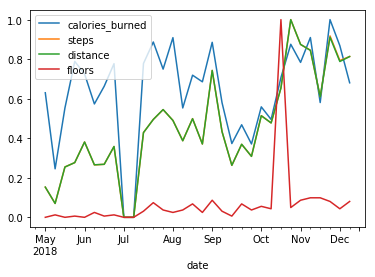

In [620]:
plot_act_week(tuesdays_s)